<a href="https://colab.research.google.com/github/BalytskyiJaroslaw/RAPID-Net/blob/main/RAPID_Net_demo_for_ABHD5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title **🔧 Set Up the Environment in Colab (Open Babel)** { display-mode: "form" }
# @markdown This installs Open Babel with Python bindings using Ubuntu packages (most reliable on Colab).
# @markdown If that fails, it falls back to the `openbabel-wheel` PyPI wheel.

import sys, subprocess, os

def sh(cmd, quiet=False):
    if quiet:
        return subprocess.run(
            cmd, stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT, check=False
        )
    else:
        print(">", " ".join(cmd))
        return subprocess.run(cmd, check=False)

print("🐍 Python:", sys.version)

# 1) Prefer Ubuntu packages (fast, if available)
print("\n📦 Installing system Open Babel (apt) ...")
sh(["apt-get", "update", "-y"], quiet=True)
ret1 = sh(["apt-get", "install", "-y", "openbabel", "python3-openbabel"], quiet=True).returncode

def try_import():
    try:
        import openbabel as ob
        from openbabel import pybel
        return True, ob
    except Exception as e:
        return False, e

ok, ob_or_err = try_import()
if ok:
    print("✅ Open Babel (apt) is ready.")
    # Show CLI version too
    sh(["obabel", "-V"])
else:
    print("⚠️ Apt route didn’t yield importable bindings:", repr(ob_or_err))
    print("\n🔁 Falling back to PyPI wheel (openbabel-wheel)...")

    # 2) PyPI fallback — latest wheel that supports recent Pythons
    rc = sh([sys.executable, "-m", "pip", "install", "-q", "openbabel-wheel"], quiet=True).returncode
    if rc != 0:
        raise RuntimeError("pip install openbabel-wheel failed.")

    ok, ob_or_err = try_import()
    if not ok:
        raise RuntimeError(
            "Open Babel import failed via both apt and wheel fallback.\n"
            "Scroll up to see the first traceback and send it to me."
        )
    else:
        print("✅ Open Babel (wheel) is ready.")

# 3) Quick smoke test with Pybel
print("\n🧪 Pybel smoke test (SMILES → molecule + add hydrogens)")
try:
    from openbabel import pybel
    m = pybel.readstring("smi", "CCO")
    m.addh()
    print("   ✅ Pybel OK (ethanol with hydrogens).")
except Exception as e:
    print("   ⚠️ Pybel test failed:", repr(e))

print("\n🎉 Open Babel setup complete!")

# OPTIONAL: if you ever *do* need a runtime restart, keep it here in cell 1:
# from google.colab import runtime
# runtime.restart_runtime()
# (Leave it commented for now; with pip wheels we don't need a restart.)


🐍 Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

📦 Installing system Open Babel (apt) ...
⚠️ Apt route didn’t yield importable bindings: ModuleNotFoundError("No module named '_openbabel'")

🔁 Falling back to PyPI wheel (openbabel-wheel)...
✅ Open Babel (wheel) is ready.

🧪 Pybel smoke test (SMILES → molecule + add hydrogens)
   ✅ Pybel OK (ethanol with hydrogens).

🎉 Open Babel setup complete!


In [2]:
# @title **🦁 Initialize the RAPID-Net Model** { display-mode: "form" }
# @markdown RAPID-Net model parameters for pocket detection.
# @markdown - The **voxel classification threshold** is the minimum density `threshold_input` for a voxel to be considered part of a pocket. *(Default: 0.5)*
# @markdown - In other words, the $2\,Å\times 2\,Å \times 2\,Å$ voxel is added to the pocket if probability > 50% by default.
# @markdown - **"Minority-reported"** pockets include voxels detected by at least `min_vote_minimal` models from an ensemble of 5 models. *(Default: 1)*
# @markdown - **"Majority-voted"** pockets include voxels detected by at least `min_vote_majority` models from an ensemble. *(Default: 3)*
import warnings
warnings.filterwarnings('ignore')

threshold_input = 0.5  # @param {type:"number"}
min_vote_minimal = 1   # @param {type:"integer"}
min_vote_majority = 3   # @param {type:"integer"}

import contextlib, sys, subprocess

print("🔄 Installing dependencies (py3Dmol, Biopython, RDKit, Meeko, PyMOL, Gemmi)...")

def pip_install(args):
    print(">", "pip install", " ".join(args))
    subprocess.run([sys.executable, "-m", "pip", "install"] + args, check=False)

# Install all needed Python deps via pip
# - gemmi is a hidden dependency of meeko
# - pymol-open-source provides PyMOL
pip_install(["-q", "gemmi", "meeko", "py3Dmol", "biopython", "rdkit", "pymol-open-source"])

print("✅ Dependencies installed!")

# ---- Imports / smoke tests ----

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate,
    BatchNormalization, Activation, add, SpatialDropout3D,
    GlobalAveragePooling3D, Reshape, Dense, multiply, LayerNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import os
from Bio.PDB import PDBParser
import numpy as np

import py3Dmol
from rdkit import Chem

import meeko  # this was failing before, should work now

# PyMOL
try:
    import pymol
    from pymol import cmd
    print("🧪 PyMOL imported OK.")
    try:
        v = cmd.get_version()
        print("   PyMOL version:", v)
    except Exception:
        pass
except Exception as e:
    print("⚠️ PyMOL import failed:", repr(e))
    print("    Check the pip output above for errors.")

print("✅ All core imports done.")

def identity_block(input_tensor, filters, stage, block):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block(input_tensor, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters
    bn_axis = -1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv3D(filters1, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters2, (3, 3, 3), padding='same', kernel_initializer='he_normal', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv3D(filters3, (1, 1, 1), kernel_initializer='he_normal', name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv3D(filters3, (1, 1, 1), strides=strides, kernel_initializer='he_normal', name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x

def se_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = GlobalAveragePooling3D()(input_tensor)
    se = Reshape((1, 1, 1, filters))(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    x = multiply([input_tensor, se])
    return x

def RAPID_Net(input_shape=(36, 36, 36, 18), filters=18, dropout_rate=0.5, l2_lambda=1e-3):
    params = {'kernel_size': 3, 'activation': 'relu', 'padding': 'same', 'kernel_regularizer': l2(l2_lambda)}

    inputs = Input(shape=input_shape, name='input')

    x = conv_block(inputs, [filters, filters, filters], stage=2, block='a', strides=(1, 1, 1))
    x1 = identity_block(x, [filters, filters, filters], stage=2, block='b')

    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(x1)

    x = conv_block(pool1, [filters*2, filters*2, filters*2], stage=4, block='a', strides=(1, 1, 1))
    x2 = identity_block(x, [filters*2, filters*2, filters*2], stage=4, block='b')

    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(x2)

    x = conv_block(pool2, [filters*4, filters*4, filters*4], stage=5, block='a', strides=(1, 1, 1))
    x3 = identity_block(x, [filters*4, filters*4, filters*4], stage=5, block='b')

    pool3 = MaxPooling3D(pool_size=(3, 3, 3))(x3)

    x = conv_block(pool3, [filters*8, filters*8, filters*8], stage=6, block='a', strides=(1, 1, 1))
    x4 = identity_block(x, [filters*8, filters*8, filters*8], stage=6, block='b')

    pool4 = MaxPooling3D(pool_size=(3, 3, 3))(x4)

    x = conv_block(pool4, [filters*16, filters*16, filters*16], stage=7, block='a', strides=(1, 1, 1))
    x = identity_block(x, [filters*16, filters*16, filters*16], stage=7, block='b')

    x = se_block(x)

    up6 = concatenate([UpSampling3D(size=(3, 3, 3))(x), x4], axis=-1)
    conv6 = Conv3D(filters=filters*8, **params)(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    conv6 = Conv3D(filters=filters*8, **params)(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    up7 = concatenate([UpSampling3D(size=(3, 3, 3))(conv6), x3], axis=-1)
    conv7 = Conv3D(filters=filters*4, **params)(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    conv7 = Conv3D(filters=filters*4, **params)(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    up8 = concatenate([UpSampling3D(size=(2, 2, 2))(conv7), x2], axis=-1)
    conv8 = Conv3D(filters=filters*2, **params)(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    conv8 = Conv3D(filters=filters*2, **params)(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)

    up9 = concatenate([UpSampling3D(size=(2, 2, 2))(conv8), x1], axis=-1)
    conv9 = Conv3D(filters=filters, **params)(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    conv9 = Conv3D(filters=filters, **params)(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)

    outputs = Conv3D(filters=1, kernel_size=1, kernel_regularizer=l2(1e-4), activation='relu', name='pocket')(conv9)

    model = Model(inputs=inputs, outputs=outputs, name='RAPID_Net')
    return model


def pocket_density_from_mol_RAPID_Net_run1(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run1.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run2(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run2.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run3(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run3.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run4(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run4.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

def pocket_density_from_mol_RAPID_Net_run5(mol):
    if not isinstance(mol, pybel.Molecule):
        raise TypeError('mol should be a pybel.Molecule object, got %s '
                        'instead' % type(mol))
    if featurizer is None:
        raise ValueError('featurizer must be set to make predistions for '
                         'molecules')
    if scale is None:
        raise ValueError('scale must be set to make predistions')
    prot_coords, prot_features = featurizer.get_features(mol)
    centroid = prot_coords.mean(axis=0)
    prot_coords -= centroid


    resolution = 1. / scale
    x = make_grid(prot_coords, prot_features,
                              max_dist= max_dist,
                              grid_resolution=resolution)
    density = RAPID_Net_run5.predict(x)

    origin = (centroid - max_dist)
    step = np.array([1.0 / scale] * 3)

    return density, origin, step

from skimage.morphology import closing, label
from skimage.segmentation import clear_border
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

def minimal_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=10, scale=0.5, voters = min_vote_minimal):

    voxel_size = (1 / scale) ** 3

    bw1 = closing((density1[0] > threshold).any(axis=-1))
    bw2 = closing((density2[0] > threshold).any(axis=-1))
    bw3 = closing((density3[0] > threshold).any(axis=-1))
    bw4 = closing((density4[0] > threshold).any(axis=-1))
    bw5 = closing((density5[0] > threshold).any(axis=-1))


    # Minimally-reported pockets, voted by at least one model
    combined_bw = np.sum([bw1, bw2, bw3, bw4, bw5], axis=0) >= voters

    # Apply morphological closing to reduce fragmentation
    combined_bw = ndi.binary_closing(combined_bw, structure=np.ones((3, 3, 3)))

    # Clear boundary-connected regions
    cleared = clear_border(combined_bw)

    # Label connected regions
    label_image, num_labels = label(cleared, return_num=True)

    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image

def ensembled_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=50, scale=0.5, voters = min_vote_majority):

    voxel_size = (1 / scale) ** 3

    bw1 = closing((density1[0] > threshold).any(axis=-1))
    bw2 = closing((density2[0] > threshold).any(axis=-1))
    bw3 = closing((density3[0] > threshold).any(axis=-1))
    bw4 = closing((density4[0] > threshold).any(axis=-1))
    bw5 = closing((density5[0] > threshold).any(axis=-1))

    # Majority-voted pockets, predicted by at least 3 models.
    combined_bw = np.sum([bw1, bw2, bw3, bw4, bw5], axis=0) >= voters

    # Apply morphological closing to reduce fragmentation
    combined_bw = ndi.binary_closing(combined_bw, structure=np.ones((3, 3, 3)))

    cleared = clear_border(combined_bw)

    label_image, num_labels = label(cleared, return_num=True)

    for i in range(1, num_labels + 1):
        pocket_idx = (label_image == i)
        pocket_size = pocket_idx.sum() * voxel_size
        if pocket_size < min_size:
            label_image[np.where(pocket_idx)] = 0

    return label_image


def save_pocket_mol2_RAPID_Net_Majority(mol, path, format, **pocket_kwargs):

    density1, origin1, step1 = pocket_density_from_mol_RAPID_Net_run1(mol)
    density1 = np.clip(density1, 0, 1)

    density2, origin2, step2 = pocket_density_from_mol_RAPID_Net_run2(mol)
    density2 = np.clip(density2, 0, 1)

    density3, origin3, step3 = pocket_density_from_mol_RAPID_Net_run3(mol)
    density3 = np.clip(density3, 0, 1)

    density4, origin4, step4 = pocket_density_from_mol_RAPID_Net_run4(mol)
    density4 = np.clip(density4, 0, 1)

    density5, origin5, step5 = pocket_density_from_mol_RAPID_Net_run5(mol)
    density5 = np.clip(density5, 0, 1)

    pockets = ensembled_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=50, scale=0.5, voters = min_vote_majority)

    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step1
        indices += origin1
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)


        # Formatting threshold (e.g., 0.5 → 05, 0.25 → 025)
        threshold_str = f"{threshold_input:.2f}".replace(".", "")
        p_mol.write(format, f"{path}/pocket_thr{threshold_str}_Majority{i}.{format}")

        i += 1

def save_pocket_mol2_RAPID_Net_Minimal(mol, path, format, **pocket_kwargs):

    density1, origin1, step1 = pocket_density_from_mol_RAPID_Net_run1(mol)
    density1 = np.clip(density1, 0, 1)

    density2, origin2, step2 = pocket_density_from_mol_RAPID_Net_run2(mol)
    density2 = np.clip(density2, 0, 1)

    density3, origin3, step3 = pocket_density_from_mol_RAPID_Net_run3(mol)
    density3 = np.clip(density3, 0, 1)

    density4, origin4, step4 = pocket_density_from_mol_RAPID_Net_run4(mol)
    density4 = np.clip(density4, 0, 1)

    density5, origin5, step5 = pocket_density_from_mol_RAPID_Net_run5(mol)
    density5 = np.clip(density5, 0, 1)

    pockets = minimal_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=10, scale=0.5, voters = min_vote_minimal)

    i = 0
    for pocket_label in range(1, pockets.max() + 1):
        indices = np.argwhere(pockets == pocket_label).astype('float')
        indices *= step1
        indices += origin1
        mol = openbabel.OBMol()
        for idx in indices:
            a = mol.NewAtom()
            a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
        p_mol = pybel.Molecule(mol)

        # Formatting threshold (e.g., 0.5 → 05, 0.25 → 025)
        threshold_str = f"{threshold_input:.2f}".replace(".", "")
        p_mol.write(format, f"{path}/pocket_thr{threshold_str}_Minimal{i}.{format}")

        i += 1

def save_pocket_mol2_RAPID_Net_Combined(mol, path, format, **pocket_kwargs):
    # Combined function to predict both majority-voted and minority-reported pockets.
    density1, origin1, step1 = pocket_density_from_mol_RAPID_Net_run1(mol)
    density1 = np.clip(density1, 0, 1)

    density2, origin2, step2 = pocket_density_from_mol_RAPID_Net_run2(mol)
    density2 = np.clip(density2, 0, 1)

    density3, origin3, step3 = pocket_density_from_mol_RAPID_Net_run3(mol)
    density3 = np.clip(density3, 0, 1)

    density4, origin4, step4 = pocket_density_from_mol_RAPID_Net_run4(mol)
    density4 = np.clip(density4, 0, 1)

    density5, origin5, step5 = pocket_density_from_mol_RAPID_Net_run5(mol)
    density5 = np.clip(density5, 0, 1)

    pockets_majority = ensembled_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=50, scale=0.5, voters = min_vote_majority)
    pockets_minimal = minimal_pockets_segmentation(density1, density2, density3, density4, density5, threshold=threshold_input, min_size=10, scale=0.5, voters = min_vote_minimal)

    def save_pockets(pockets, label):
        i = 0
        for pocket_label in range(1, pockets.max() + 1):
            indices = np.argwhere(pockets == pocket_label).astype('float')
            indices *= step1
            indices += origin1
            mol = openbabel.OBMol()
            for idx in indices:
                a = mol.NewAtom()
                a.SetVector(float(idx[0]), float(idx[1]), float(idx[2]))
            p_mol = pybel.Molecule(mol)

            # Formatting threshold (e.g., 0.5 → 05, 0.25 → 025)
            threshold_str = f"{threshold_input:.2f}".replace(".", "")
            p_mol.write(format, f"{path}/pocket_thr{threshold_str}_{label}{i}.{format}")
            i += 1

    # Save both types of pockets
    save_pockets(pockets_majority, "Majority")
    save_pockets(pockets_minimal, "Minimal")

def count_atoms_in_pdb(file_path):
    """Count atoms in PDB file to erase empty pockets"""
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return sum(1 for line in lines if line.startswith("ATOM") or line.startswith("HETATM"))

def calculate_distance(atom1, atom2):
    """Calculates the distance between two atoms."""
    coord1 = np.array(atom1.get_coord())
    coord2 = np.array(atom2.get_coord())
    return np.linalg.norm(coord1 - coord2)

def is_within_distance(protein_atoms, pocket_file, distance_threshold=20.0):
    """
    Checks if every atom in the pocket file is within 'distance_threshold' Å
    of at least one atom in the list of 'protein_atoms'.
    If any pocket atom is farther than 'distance_threshold' Å from all protein atoms,
    return False.
    """
    parser = PDBParser(QUIET=True)
    pocket_structure = parser.get_structure("Pocket", pocket_file)

    for pocket_model in pocket_structure:
        for pocket_chain in pocket_model:
            for pocket_residue in pocket_chain:
                for pocket_atom in pocket_residue:
                    # Check if this pocket_atom is within the threshold for ANY protein atom
                    within_threshold = any(
                        calculate_distance(pocket_atom, protein_atom) <= distance_threshold
                        for protein_atom in protein_atoms
                    )
                    if not within_threshold:
                        # Found a pocket atom that is NOT within threshold of any protein atom
                        return False

    # If we never returned False, it means all pocket atoms were within threshold
    return True

def remove_invalid_pockets(protein_file, folder_path, distance_threshold=8.0):
    """Removes empty pockets and those beyond the distance threshold from the protein."""
    parser = PDBParser(QUIET=True)
    protein_structure = parser.get_structure("Protein", protein_file)

    # Extract all protein atoms
    protein_atoms = [atom for model in protein_structure
                     for chain in model
                     for residue in chain
                     for atom in residue]

    remaining_pocket_files = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith("pocket") and file_name.endswith(".pdb"):
            pocket_file_path = os.path.join(folder_path, file_name)

            # Check if the file is empty (zero atoms)
            if count_atoms_in_pdb(pocket_file_path) == 0:
                os.remove(pocket_file_path)
                print(f"Deleted empty pocket file: {file_name}")
                continue

            # Check if the file is within the required distance
            if not is_within_distance(protein_atoms, pocket_file_path, distance_threshold):
                os.remove(pocket_file_path)
                print(f"Removed junk: {file_name}")
            else:
                remaining_pocket_files.append(pocket_file_path)
                print(f"Retained pocket file: {file_name}")

    print("\nFinal list of retained pocket files:")
    for file in remaining_pocket_files:
        print(file)


# Featurizer from tfbio package
# https://gitlab.com/cheminfIBB/tfbio
import os
import numpy as np
import py3Dmol
import scipy.stats as stats
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import colors

from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolTransforms, rdDepictor, rdForceFieldHelpers
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole
from IPython.display import SVG, Image
import ipywidgets as widgets

from openbabel import pybel

import pickle
from math import ceil, sin, cos, sqrt, pi
from itertools import combinations

from statistics import mean, stdev

class Featurizer():
    """Calcaulates atomic features for molecules. Features can encode atom type,
    native pybel properties or any property defined with SMARTS patterns

    Attributes
    ----------
    FEATURE_NAMES: list of strings
        Labels for features (in the same order as features)
    NUM_ATOM_CLASSES: int
        Number of atom codes
    ATOM_CODES: dict
        Dictionary mapping atomic numbers to codes
    NAMED_PROPS: list of string
        Names of atomic properties to retrieve from pybel.Atom object
    CALLABLES: list of callables
        Callables used to calculcate custom atomic properties
    SMARTS: list of SMARTS strings
        SMARTS patterns defining additional atomic properties
    """

    def __init__(self, atom_codes=None, atom_labels=None,
                 named_properties=None, save_molecule_codes=True,
                 custom_properties=None, smarts_properties=None,
                 smarts_labels=None):

        """Creates Featurizer with specified types of features. Elements of a
        feature vector will be in a following order: atom type encoding
        (defined by atom_codes), Pybel atomic properties (defined by
        named_properties), molecule code (if present), custom atomic properties
        (defined `custom_properties`), and additional properties defined with
        SMARTS (defined with `smarts_properties`).

        Parameters
        ----------
        atom_codes: dict, optional
            Dictionary mapping atomic numbers to codes. It will be used for
            one-hot encoging therefore if n different types are used, codes
            shpuld be from 0 to n-1. Multiple atoms can have the same code,
            e.g. you can use {6: 0, 7: 1, 8: 1} to encode carbons with [1, 0]
            and nitrogens and oxygens with [0, 1] vectors. If not provided,
            default encoding is used.
        atom_labels: list of strings, optional
            Labels for atoms codes. It should have the same length as the
            number of used codes, e.g. for `atom_codes={6: 0, 7: 1, 8: 1}` you
            should provide something like ['C', 'O or N']. If not specified
            labels 'atom0', 'atom1' etc are used. If `atom_codes` is not
            specified this argument is ignored.
        named_properties: list of strings, optional
            Names of atomic properties to retrieve from pybel.Atom object. If
            not specified ['hyb', 'heavyvalence', 'heterovalence',
            'partialcharge'] is used.
        save_molecule_codes: bool, optional (default True)
            If set to True, there will be an additional feature to save
            molecule code. It is usefeul when saving molecular complex in a
            single array.
        custom_properties: list of callables, optional
            Custom functions to calculate atomic properties. Each element of
            this list should be a callable that takes pybel.Atom object and
            returns a float. If callable has `__name__` property it is used as
            feature label. Otherwise labels 'func<i>' etc are used, where i is
            the index in `custom_properties` list.
        smarts_properties: list of strings, optional
            Additional atomic properties defined with SMARTS patterns. These
            patterns should match a single atom. If not specified, deafult
            patterns are used.
        smarts_labels: list of strings, optional
            Labels for properties defined with SMARTS. Should have the same
            length as `smarts_properties`. If not specified labels 'smarts0',
            'smarts1' etc are used. If `smarts_properties` is not specified
            this argument is ignored.
        """

        # Remember namse of all features in the correct order
        self.FEATURE_NAMES = []

        if atom_codes is not None:
            if not isinstance(atom_codes, dict):
                raise TypeError('Atom codes should be dict, got %s instead'
                                % type(atom_codes))
            codes = set(atom_codes.values())
            for i in range(len(codes)):
                if i not in codes:
                    raise ValueError('Incorrect atom code %s' % i)

            self.NUM_ATOM_CLASSES = len(codes)
            self.ATOM_CODES = atom_codes
            if atom_labels is not None:
                if len(atom_labels) != self.NUM_ATOM_CLASSES:
                    raise ValueError('Incorrect number of atom labels: '
                                     '%s instead of %s'
                                     % (len(atom_labels), self.NUM_ATOM_CLASSES))
            else:
                atom_labels = ['atom%s' % i for i in range(self.NUM_ATOM_CLASSES)]
            self.FEATURE_NAMES += atom_labels
        else:
            self.ATOM_CODES = {}

            metals = ([3, 4, 11, 12, 13] + list(range(19, 32))
                      + list(range(37, 51)) + list(range(55, 84))
                      + list(range(87, 104)))

            # List of tuples (atomic_num, class_name) with atom types to encode.
            atom_classes = [
                (5, 'B'),
                (6, 'C'),
                (7, 'N'),
                (8, 'O'),
                (15, 'P'),
                (16, 'S'),
                (34, 'Se'),
                ([9, 17, 35, 53], 'halogen'),
                (metals, 'metal')
            ]

            for code, (atom, name) in enumerate(atom_classes):
                if type(atom) is list:
                    for a in atom:
                        self.ATOM_CODES[a] = code
                else:
                    self.ATOM_CODES[atom] = code
                self.FEATURE_NAMES.append(name)

            self.NUM_ATOM_CLASSES = len(atom_classes)

        if named_properties is not None:
            if not isinstance(named_properties, (list, tuple, np.ndarray)):
                raise TypeError('named_properties must be a list')
            allowed_props = [prop for prop in dir(pybel.Atom)
                             if not prop.startswith('__')]
            for prop_id, prop in enumerate(named_properties):
                if prop not in allowed_props:
                    raise ValueError(
                        'named_properties must be in pybel.Atom attributes,'
                        ' %s was given at position %s' % (prop_id, prop)
                    )
            self.NAMED_PROPS = named_properties
        else:
            # pybel.Atom properties to save
            self.NAMED_PROPS = ['hyb', 'heavydegree', 'heterodegree',
                                'partialcharge']
        self.FEATURE_NAMES += self.NAMED_PROPS

        if not isinstance(save_molecule_codes, bool):
            raise TypeError('save_molecule_codes should be bool, got %s '
                            'instead' % type(save_molecule_codes))
        self.save_molecule_codes = save_molecule_codes
        if save_molecule_codes:
            # Remember if an atom belongs to the ligand or to the protein
            self.FEATURE_NAMES.append('molcode')

        self.CALLABLES = []
        if custom_properties is not None:
            for i, func in enumerate(custom_properties):
                if not callable(func):
                    raise TypeError('custom_properties should be list of'
                                    ' callables, got %s instead' % type(func))
                name = getattr(func, '__name__', '')
                if name == '':
                    name = 'func%s' % i
                self.CALLABLES.append(func)
                self.FEATURE_NAMES.append(name)

        if smarts_properties is None:
            # SMARTS definition for other properties
            self.SMARTS = [
                '[#6+0!$(*~[#7,#8,F]),SH0+0v2,s+0,S^3,Cl+0,Br+0,I+0]',
                '[a]',
                '[!$([#1,#6,F,Cl,Br,I,o,s,nX3,#7v5,#15v5,#16v4,#16v6,*+1,*+2,*+3])]',
                '[!$([#6,H0,-,-2,-3]),$([!H0;#7,#8,#9])]',
                '[r]'
            ]
            smarts_labels = ['hydrophobic', 'aromatic', 'acceptor', 'donor',
                             'ring']
        elif not isinstance(smarts_properties, (list, tuple, np.ndarray)):
            raise TypeError('smarts_properties must be a list')
        else:
            self.SMARTS = smarts_properties

        if smarts_labels is not None:
            if len(smarts_labels) != len(self.SMARTS):
                raise ValueError('Incorrect number of SMARTS labels: %s'
                                 ' instead of %s'
                                 % (len(smarts_labels), len(self.SMARTS)))
        else:
            smarts_labels = ['smarts%s' % i for i in range(len(self.SMARTS))]

        # Compile patterns
        self.compile_smarts()
        self.FEATURE_NAMES += smarts_labels

    def compile_smarts(self):
        self.__PATTERNS = []
        for smarts in self.SMARTS:
            self.__PATTERNS.append(pybel.Smarts(smarts))

    def encode_num(self, atomic_num):
        """Encode atom type with a binary vector. If atom type is not included in
        the `atom_classes`, its encoding is an all-zeros vector.

        Parameters
        ----------
        atomic_num: int
            Atomic number

        Returns
        -------
        encoding: np.ndarray
            Binary vector encoding atom type (one-hot or null).
        """

        if not isinstance(atomic_num, int):
            raise TypeError('Atomic number must be int, %s was given'
                            % type(atomic_num))

        encoding = np.zeros(self.NUM_ATOM_CLASSES)
        try:
            encoding[self.ATOM_CODES[atomic_num]] = 1.0
        except:
            pass
        return encoding

    def find_smarts(self, molecule):
        """Find atoms that match SMARTS patterns.

        Parameters
        ----------
        molecule: pybel.Molecule

        Returns
        -------
        features: np.ndarray
            NxM binary array, where N is the number of atoms in the `molecule`
            and M is the number of patterns. `features[i, j]` == 1.0 if i'th
            atom has j'th property
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object, %s was given'
                            % type(molecule))

        features = np.zeros((len(molecule.atoms), len(self.__PATTERNS)))

        for (pattern_id, pattern) in enumerate(self.__PATTERNS):
            atoms_with_prop = np.array(list(*zip(*pattern.findall(molecule))),
                                       dtype=int) - 1
            features[atoms_with_prop, pattern_id] = 1.0
        return features

    def get_features(self, molecule, molcode=None):
        """Get coordinates and features for all heavy atoms in the molecule.

        Parameters
        ----------
        molecule: pybel.Molecule
        molcode: float, optional
            Molecule type. You can use it to encode whether an atom belongs to
            the ligand (1.0) or to the protein (-1.0) etc.

        Returns
        -------
        coords: np.ndarray, shape = (N, 3)
            Coordinates of all heavy atoms in the `molecule`.
        features: np.ndarray, shape = (N, F)
            Features of all heavy atoms in the `molecule`: atom type
            (one-hot encoding), pybel.Atom attributes, type of a molecule
            (e.g protein/ligand distinction), and other properties defined with
            SMARTS patterns
        """

        if not isinstance(molecule, pybel.Molecule):
            raise TypeError('molecule must be pybel.Molecule object,'
                            ' %s was given' % type(molecule))
        if molcode is None:
            if self.save_molecule_codes is True:
                raise ValueError('save_molecule_codes is set to True,'
                                 ' you must specify code for the molecule')
        elif not isinstance(molcode, (float, int)):
            raise TypeError('motlype must be float, %s was given'
                            % type(molcode))

        coords = []
        features = []
        heavy_atoms = []

        for i, atom in enumerate(molecule):
            # ignore hydrogens and dummy atoms (they have atomicnum set to 0)
            if atom.atomicnum > 1:
                heavy_atoms.append(i)
                coords.append(atom.coords)

                features.append(np.concatenate((
                    self.encode_num(atom.atomicnum),
                    [atom.__getattribute__(prop) for prop in self.NAMED_PROPS],
                    [func(atom) for func in self.CALLABLES],
                )))

        coords = np.array(coords, dtype=np.float32)
        features = np.array(features, dtype=np.float32)
        if self.save_molecule_codes:
            features = np.hstack((features,
                                  molcode * np.ones((len(features), 1))))
        features = np.hstack([features,
                              self.find_smarts(molecule)[heavy_atoms]])

        if np.isnan(features).any():
            raise RuntimeError('Got NaN when calculating features')

        return coords, features

    def to_pickle(self, fname='featurizer.pkl'):
        """Save featurizer in a given file. Featurizer can be restored with
        `from_pickle` method.

        Parameters
        ----------
        fname: str, optional
           Path to file in which featurizer will be saved
        """

        # patterns can't be pickled, we need to temporarily remove them
        patterns = self.__PATTERNS[:]
        del self.__PATTERNS
        try:
            with open(fname, 'wb') as f:
                pickle.dump(self, f)
        finally:
            self.__PATTERNS = patterns[:]

    @staticmethod
    def from_pickle(fname):
        """Load pickled featurizer from a given file

        Parameters
        ----------
        fname: str, optional
           Path to file with saved featurizer

        Returns
        -------
        featurizer: Featurizer object
           Loaded featurizer
        """
        with open(fname, 'rb') as f:
            featurizer = pickle.load(f)
        featurizer.compile_smarts()
        return featurizer


def rotation_matrix(axis, theta):
    """Counterclockwise rotation about a given axis by theta radians"""

    if not isinstance(axis, (np.ndarray, list, tuple)):
        raise TypeError('axis must be an array of floats of shape (3,)')
    try:
        axis = np.asarray(axis, dtype=np.float64)
    except ValueError:
        raise ValueError('axis must be an array of floats of shape (3,)')

    if axis.shape != (3,):
        raise ValueError('axis must be an array of floats of shape (3,)')

    if not isinstance(theta, (float, int)):
        raise TypeError('theta must be a float')

    axis = axis / sqrt(np.dot(axis, axis))
    a = cos(theta / 2.0)
    b, c, d = -axis * sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


# Create matrices for all possible 90* rotations of a box
ROTATIONS = [rotation_matrix([1, 1, 1], 0)]

# about X, Y and Z - 9 rotations
for a1 in range(3):
    for t in range(1, 4):
        axis = np.zeros(3)
        axis[a1] = 1
        theta = t * pi / 2.0
        ROTATIONS.append(rotation_matrix(axis, theta))

# about each face diagonal - 6 rotations
for (a1, a2) in combinations(range(3), 2):
    axis = np.zeros(3)
    axis[[a1, a2]] = 1.0
    theta = pi
    ROTATIONS.append(rotation_matrix(axis, theta))
    axis[a2] = -1.0
    ROTATIONS.append(rotation_matrix(axis, theta))

# about each space diagonal - 8 rotations
for t in [1, 2]:
    theta = t * 2 * pi / 3
    axis = np.ones(3)
    ROTATIONS.append(rotation_matrix(axis, theta))
    for a1 in range(3):
        axis = np.ones(3)
        axis[a1] = -1
        ROTATIONS.append(rotation_matrix(axis, theta))


def rotate(coords, rotation):
    """Rotate coordinates by a given rotation

    Parameters
    ----------
    coords: array-like, shape (N, 3)
        Arrays with coordinates and features for each atoms.
    rotation: int or array-like, shape (3, 3)
        Rotation to perform. You can either select predefined rotation by
        giving its index or specify rotation matrix.

    Returns
    -------
    coords: np.ndarray, shape = (N, 3)
        Rotated coordinates.
    """

    global ROTATIONS

    if not isinstance(coords, (np.ndarray, list, tuple)):
        raise TypeError('coords must be an array of floats of shape (N, 3)')
    try:
        coords = np.asarray(coords, dtype=np.float64)
    except ValueError:
        raise ValueError('coords must be an array of floats of shape (N, 3)')
    shape = coords.shape
    if len(shape) != 2 or shape[1] != 3:
        raise ValueError('coords must be an array of floats of shape (N, 3)')

    if isinstance(rotation, int):
        if rotation >= 0 and rotation < len(ROTATIONS):
            return np.dot(coords, ROTATIONS[rotation])
        else:
            raise ValueError('Invalid rotation number %s!' % rotation)
    elif isinstance(rotation, np.ndarray) and rotation.shape == (3, 3):
        return np.dot(coords, rotation)

    else:
        raise ValueError('Invalid rotation %s!' % rotation)

def make_grid(coords, features, grid_resolution=1.0, max_dist=10.0):
    """Convert atom coordinates and features represented as 2D arrays into a
    fixed-sized 3D box.

    Parameters
    ----------
    coords, features: array-likes, shape (N, 3) and (N, F)
        Arrays with coordinates and features for each atoms.
    grid_resolution: float, optional
        Resolution of a grid (in Angstroms).
    max_dist: float, optional
        Maximum distance between atom and box center. Resulting box has size of
        2*`max_dist`+1 Angstroms and atoms that are too far away are not
        included.

    Returns
    -------
    coords: np.ndarray, shape = (M, M, M, F)
        4D array with atom properties distributed in 3D space. M is equal to
        2 * `max_dist` / `grid_resolution` + 1
    """

    try:
        coords = np.asarray(coords, dtype=np.float64)
    except ValueError:
        raise ValueError('coords must be an array of floats of shape (N, 3)')
    c_shape = coords.shape
    if len(c_shape) != 2 or c_shape[1] != 3:
        raise ValueError('coords must be an array of floats of shape (N, 3)')

    N = len(coords)
    try:
        features = np.asarray(features, dtype=np.float64)
    except ValueError:
        raise ValueError('features must be an array of floats of shape (N, F)')
    f_shape = features.shape
    if len(f_shape) != 2 or f_shape[0] != N:
        raise ValueError('features must be an array of floats of shape (N, F)')

    if not isinstance(grid_resolution, (float, int)):
        raise TypeError('grid_resolution must be float')
    if grid_resolution <= 0:
        raise ValueError('grid_resolution must be positive')

    if not isinstance(max_dist, (float, int)):
        raise TypeError('max_dist must be float')
    if max_dist <= 0:
        raise ValueError('max_dist must be positive')

    num_features = f_shape[1]
    max_dist = float(max_dist)
    grid_resolution = float(grid_resolution)

    box_size = ceil(2 * max_dist / grid_resolution + 1)

    # move all atoms to the neares grid point
    grid_coords = (coords + max_dist) / grid_resolution
    grid_coords = grid_coords.round().astype(int)

    # remove atoms outside the box
    in_box = ((grid_coords >= 0) & (grid_coords < box_size)).all(axis=1)
    grid = np.zeros((1, box_size, box_size, box_size, num_features),
                    dtype=np.float32)
    for (x, y, z), f in zip(grid_coords[in_box], features[in_box]):
        grid[0, x, y, z] += f

    return grid

featurizer = Featurizer(save_molecule_codes = False)

scale=0.5
max_dist=35
file_format = 'pdb'

grid_resolution=1.0
scale=0.5
grid_size=36

resolution = 1. / scale
print("\n🦁 Preparing RAPID-Net model for launch...")

# Download model weights
model_files = [
    "Soft_Dice_Relu_5020_Run_1.keras",
    "Soft_Dice_Relu_5020_Run_2.keras",
    "Soft_Dice_Relu_5020_Run_3.keras",
    "Soft_Dice_Relu_5020_Run_4.keras",
    "Soft_Dice_Relu_5020_Run_5.keras"
]

print("🔄 Downloading model weights from Zenodo...")
for model_file in model_files:
    !wget -q https://zenodo.org/record/14796981/files/{model_file} -O {model_file}
    if os.path.exists(f"/content/{model_file}"):
        print(f"✅ {model_file} downloaded successfully!")
    else:
        print(f"❌ Error: {model_file} not found!")

# Initialize RAPID-Net models
print("🔄 Initializing RAPID-Net model...")
try:
    RAPID_Net_run1 = RAPID_Net()
    RAPID_Net_run2 = RAPID_Net()
    RAPID_Net_run3 = RAPID_Net()
    RAPID_Net_run4 = RAPID_Net()
    RAPID_Net_run5 = RAPID_Net()
    print("✅ RAPID-Net model initialized successfully!")
except Exception as e:
    print(f"❌ Error initializing RAPID-Net models: {e}")

# Load weights into the models
print("🔄 Loading model weights...")
try:
    RAPID_Net_run1.load_weights('/content/Soft_Dice_Relu_5020_Run_1.keras')
    print("✅ Weights loaded for RAPID_Net_run1!")

    RAPID_Net_run2.load_weights('/content/Soft_Dice_Relu_5020_Run_2.keras')
    print("✅ Weights loaded for RAPID_Net_run2!")

    RAPID_Net_run3.load_weights('/content/Soft_Dice_Relu_5020_Run_3.keras')
    print("✅ Weights loaded for RAPID_Net_run3!")

    RAPID_Net_run4.load_weights('/content/Soft_Dice_Relu_5020_Run_4.keras')
    print("✅ Weights loaded for RAPID_Net_run4!")

    RAPID_Net_run5.load_weights('/content/Soft_Dice_Relu_5020_Run_5.keras')
    print("✅ Weights loaded for RAPID_Net_run5!")

    print("\n🎉 RAPID-Net model 🦁 unleashed and ready for pocket prediction! 🚀")
except Exception as e:
    print(f"❌ Error loading model weights: {e}")

🔄 Installing dependencies (py3Dmol, Biopython, RDKit, Meeko, PyMOL, Gemmi)...
> pip install -q gemmi meeko py3Dmol biopython rdkit pymol-open-source
✅ Dependencies installed!
🧪 PyMOL imported OK.
   PyMOL version: ('3.2.0a', 3.0, 3000000, 1754317088, '7e6dafa700aba746ad963d5057748dbb8f87cbc6', 0)
✅ All core imports done.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



🦁 Preparing RAPID-Net model for launch...
🔄 Downloading model weights from Zenodo...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Soft_Dice_Relu_5020_Run_1.keras downloaded successfully!
✅ Soft_Dice_Relu_5020_Run_2.keras downloaded successfully!
✅ Soft_Dice_Relu_5020_Run_3.keras downloaded successfully!
✅ Soft_Dice_Relu_5020_Run_4.keras downloaded successfully!
✅ Soft_Dice_Relu_5020_Run_5.keras downloaded successfully!
🔄 Initializing RAPID-Net model...
✅ RAPID-Net model initialized successfully!
🔄 Loading model weights...
✅ Weights loaded for RAPID_Net_run1!
✅ Weights loaded for RAPID_Net_run2!
✅ Weights loaded for RAPID_Net_run3!
✅ Weights loaded for RAPID_Net_run4!
✅ Weights loaded for RAPID_Net_run5!

🎉 RAPID-Net model 🦁 unleashed and ready for pocket prediction! 🚀


In [3]:
# @title **🛠 Create a Repository for Your Protein, Predict Pockets, and Prepare Protein for Docking** { display-mode: "form" }
# @markdown Enter the **protein name** and upload the file.
# @markdown In this case, it is **ab5_ckfix.pdb**

from pymol import cmd

Job_name = "ABHD5"  # @param {type: "string"}

import os
import time
import subprocess
from pathlib import Path

from google.colab import files

# 🔹 IMPORTANT: you need both the module *and* pybel
import openbabel                        # NEW: fixes `name 'openbabel' is not defined`
from openbabel import pybel

from Bio.PDB import PDBParser
import numpy as np
from rdkit.Chem import AddHs, MolFromMolFile

Prediction_Type = "Both Majority and Minimal"  # @param ["Majority", "Minimal", "Both Majority and Minimal"]

# Ensure a valid name is provided
invalid_chars = '^<>/\\{}[]~`$ '
assert Job_name, '⚠️ Please provide a name for the protein!'
assert not set(invalid_chars).intersection(Job_name), '⚠️ Name contains disallowed characters!'

# Create the protein repository (directory)
WRK_DIR = os.path.join(os.getcwd(), Job_name)
os.makedirs(WRK_DIR, exist_ok=True)

print("\n" + "="*50)
print(f"✅ Protein Repository Created: `{Job_name}`")
print(f"📂 Directory: `{WRK_DIR}`")
print("="*50)

# Upload protein file
print("\n📤 Please upload your protein file:")
uploaded = files.upload()

# Move uploaded file to the created directory
uploaded_filename = list(uploaded.keys())[0]  # Ensure only one file is processed
file_path = os.path.join(WRK_DIR, uploaded_filename)
os.rename(uploaded_filename, file_path)

print("\n" + "-"*50)
print(f"✅ File Uploaded Successfully!")
print(f"📄 File Name: `{uploaded_filename}`")
print(f"📁 Stored in: `{WRK_DIR}`")
print("-"*50)

# Define paths and formats
protein_file = os.path.join(WRK_DIR, uploaded_filename)
file_format = 'pdb'
output_format = 'pdb'

print("\n⏳ Processing Protein File... Please wait.")
time.sleep(1)

# Read the molecular structure
try:
    protein_mol = next(pybel.readfile(file_format, protein_file))
    print("✅ Molecule successfully loaded from the PDB file!")
except Exception as e:
    print(f"❌ Error loading molecule: {e}")
    protein_mol = None  # Prevent further processing if failed

# Apply the pocket prediction functions based on user choice
if protein_mol:
    print("\n🔄 Predicting Pockets...")
    try:
        if Prediction_Type == "Majority":
            save_pocket_mol2_RAPID_Net_Majority(protein_mol, WRK_DIR, output_format)
            print("✅ Majority-voted pockets generated successfully!")
        elif Prediction_Type == "Minimal":
            save_pocket_mol2_RAPID_Net_Minimal(protein_mol, WRK_DIR, output_format)
            print("✅ Minimally-reporting pockets generated successfully!")
        else:
            save_pocket_mol2_RAPID_Net_Combined(protein_mol, WRK_DIR, output_format)
            print("✅ Both Majority and Minimal pockets generated successfully!")

        remove_invalid_pockets(protein_file, WRK_DIR, distance_threshold=20.0)
        print("✅ Invalid pockets filtered out")

        print("\n🎉 Processing Complete! All outputs saved in:")
        print(f"📁 `{WRK_DIR}`")
        print("="*50)
    except Exception as e:
        print(f"❌ Error during pocket prediction: {e}")


# --------------------------
# Grid / config file helpers
# --------------------------

def process_pocket(pocket_path, pocket_name, thresholds, subfolder_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure(pocket_name, pocket_path)

    # Get all atom coordinates
    atoms = [atom for atom in structure.get_atoms()]
    coords = np.array([atom.coord for atom in atoms])

    max_coords = np.max(coords, axis=0)
    min_coords = np.min(coords, axis=0)

    center = (max_coords + min_coords) / 2

    for threshold in thresholds:
        DELTAx = (max_coords[0] - min_coords[0]) + 2 * threshold
        DELTAy = (max_coords[1] - min_coords[1]) + 2 * threshold
        DELTAz = (max_coords[2] - min_coords[2]) + 2 * threshold

        # Create config content
        config_content = f"""\
center_x = {center[0]}
center_y = {center[1]}
center_z = {center[2]}

size_x = {DELTAx}
size_y = {DELTAy}
size_z = {DELTAz}
"""
        config_filename = f"{pocket_name}_config_{threshold}.txt"
        config_file_path = os.path.join(subfolder_path, config_filename)

        # Write config file
        with open(config_file_path, 'w') as config_file:
            config_file.write(config_content)

        # Create directory for docking results
        result_dir_name = f"{pocket_name}_results_{threshold}"
        result_dir_path = os.path.join(subfolder_path, result_dir_name)
        os.makedirs(result_dir_path, exist_ok=True)

        print(f"Generated config file: {config_file_path}")
        print(f"Created results directory: {result_dir_path}")

# @markdown Specify the search grids.
majority_thresholds_input = "2"  # @param {type:"string"}
majority_thresholds = [int(thr_maj.strip()) for thr_maj in majority_thresholds_input.split(",") if thr_maj.strip().isdigit()]

minority_thresholds_input = ""  # @param {type:"string"}
minimal_thresholds = [int(thr_min.strip()) for thr_min in minority_thresholds_input.split(",") if thr_min.strip().isdigit()]

minimal_pocket_files = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Minimal" in file and file.endswith(".pdb")
]

for pocket_file in minimal_pocket_files:
    pocket_path = os.path.join(WRK_DIR, pocket_file)
    pocket_name = os.path.splitext(pocket_file)[0]
    process_pocket(pocket_path, pocket_name, minimal_thresholds, WRK_DIR)

majority_pocket_files = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Majority" in file and file.endswith(".pdb")
]

for pocket_file in majority_pocket_files:
    pocket_path = os.path.join(WRK_DIR, pocket_file)
    pocket_name = os.path.splitext(pocket_file)[0]
    process_pocket(pocket_path, pocket_name, majority_thresholds, WRK_DIR)


# -----------------------------------
# ✅ KEEP REDUCE, but install it cleanly
# -----------------------------------

def ensure_reduce():
    """
    Make sure Reduce and its HET dictionary are installed.
    Build only once per runtime; skip if already present.
    """
    reduce_executable = "/usr/local/bin/reduce"
    het_dict_path = "/usr/local/reduce_wwPDB_het_dict.txt"

    if os.path.isfile(reduce_executable) and os.path.isfile(het_dict_path):
        print("✅ Reduce already installed.")
        return reduce_executable, het_dict_path

    print("\n🔄 Installing Reduce and dependencies to add explicit hydrogens...")
    # Basic build deps
    subprocess.run("apt-get update && apt-get install -y build-essential cmake git", shell=True, check=True)

    # Clone repo (shallow)
    if not os.path.exists("/content/reduce"):
        subprocess.run("git clone --depth 1 https://github.com/rlabduke/reduce.git /content/reduce", shell=True, check=True)

    # Configure + build + install
    subprocess.run("cmake -S /content/reduce -B /content/reduce/build", shell=True, check=True)
    subprocess.run("cmake --build /content/reduce/build --target install -j2", shell=True, check=True)

    # Copy het dict into /usr/local
    subprocess.run("cp /content/reduce/reduce_wwPDB_het_dict.txt /usr/local/reduce_wwPDB_het_dict.txt", shell=True, check=True)

    if not (os.path.isfile(reduce_executable) and os.path.isfile(het_dict_path)):
        raise RuntimeError("Reduce build finished but executable or HET dict not found; check logs above.")

    print("✅ Reduce installed successfully!")
    return reduce_executable, het_dict_path


def add_hydrogens(input_file, output_file):
    """
    Use Reduce to add hydrogens to `input_file` and write `output_file`.
    Treat non-zero exit as a warning if the output file was actually written.
    """
    reduce_executable, het_dict_path = ensure_reduce()

    if not os.path.isfile(reduce_executable):
        raise FileNotFoundError(f"Reduce executable not found at {reduce_executable}")

    if not os.path.isfile(het_dict_path):
        raise FileNotFoundError(f"HET dictionary not found at {het_dict_path}")

    reduce_cmd = f"{reduce_executable} -BUILD -DB {het_dict_path} {input_file} > {output_file}"
    print(f"🔄 Running Reduce:\n   {reduce_cmd}")
    result = subprocess.run(
        reduce_cmd,
        shell=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
    )

    stdout = result.stdout.decode(errors="ignore")
    stderr = result.stderr.decode(errors="ignore")

    # Always show what Reduce said (for debugging)
    if stdout.strip():
        print("---- Reduce STDOUT ----")
        print(stdout)
    if stderr.strip():
        print("---- Reduce STDERR ----")
        print(stderr)

    # Check whether output was actually produced
    if os.path.isfile(output_file) and os.path.getsize(output_file) > 0:
        if result.returncode != 0:
            print(f"⚠️ Reduce returned non-zero exit code ({result.returncode}), "
                  f"but produced a non-empty output file. Continuing.")
        else:
            print(f"✅ Hydrogens added to {input_file} successfully.")
    else:
        # Hard error only if no usable output file
        raise RuntimeError(
            f"Reduce failed (exit {result.returncode}) and no valid output file was produced."
        )


# ---- Protonation with Reduce ----

protein_file_reduce = os.path.join(
    os.path.dirname(protein_file),
    os.path.basename(protein_file).replace('.pdb', '_reduce.pdb')
)

add_hydrogens(protein_file, protein_file_reduce)
print("✅ Protonation completed with Reduce!")


# ----------------------------
# Clean “bad” atoms using PyMOL
# ----------------------------

prot_pdb_rm_bad_path = protein_file_reduce.replace("_reduce.pdb", "_reduce_rm_bad.pdb")

def _remove_bad_atoms(file_in: str, file_out: str):
    cmd.reinitialize()

    if not os.path.exists(file_in):
        raise FileNotFoundError(f"❌ Input file not found: {file_in}")

    print(f"🔄 Processing {file_in} to remove bad atoms...")

    cmd.load(filename=file_in, object="complex")

    # Remove specific elements
    for element in ["Mo", "B", "Li", "Xe", "As", "Cs", "V", "X"]:
        cmd.remove(f"bymolecule elem {element}")

    # Save the cleaned file
    cmd.save(filename=file_out, selection="complex")

    print(f"✅ Saved cleaned protein to: {file_out}")

# Run bad atom removal
_remove_bad_atoms(protein_file_reduce, prot_pdb_rm_bad_path)
print("✅ Unwanted atoms removed using PyMOL!")


# ----------------------------
# Convert to PDBQT for docking
# ----------------------------

prot_pdbqt_file_path = prot_pdb_rm_bad_path.replace("_reduce_rm_bad.pdb", "_reduce_rm_bad_input.pdbqt")
obabel_cmd = f"obabel {prot_pdb_rm_bad_path} -xr -O {prot_pdbqt_file_path} -p 7.4 > /dev/null 2>&1"
subprocess.run(obabel_cmd, shell=True, check=True)
print("✅ Protein PDBQT file generated for docking!")



✅ Protein Repository Created: `ABHD5`
📂 Directory: `/content/ABHD5`

📤 Please upload your protein file:


Saving ab5_ckfix.pdb to ab5_ckfix.pdb

--------------------------------------------------
✅ File Uploaded Successfully!
📄 File Name: `ab5_ckfix.pdb`
📁 Stored in: `/content/ABHD5`
--------------------------------------------------

⏳ Processing Protein File... Please wait.
✅ Molecule successfully loaded from the PDB file!

🔄 Predicting Pockets...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Both Majority and Minimal pockets generated successfully!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Retained pocket file: pocket_thr050_Minimal9.pdb
Retained pocket file: pocket_thr050_Minimal15.pdb
Retained pocket file: pocket_thr050_Minimal8.pdb
Retained pocket file: pocket_thr050_Minimal1.pdb
Deleted empty pocket file: pocket_thr050_Minimal2.pdb
Retained pocket file: pocket_thr050_Minimal6.pdb
Deleted empty pocket file: pocket_thr050_Minimal13.pdb


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Retained pocket file: pocket_thr050_Minimal0.pdb
Deleted empty pocket file: pocket_thr050_Minimal12.pdb
Retained pocket file: pocket_thr050_Minimal11.pdb
Deleted empty pocket file: pocket_thr050_Minimal3.pdb
Retained pocket file: pocket_thr050_Minimal10.pdb


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Retained pocket file: pocket_thr050_Majority0.pdb
Retained pocket file: pocket_thr050_Minimal7.pdb
Deleted empty pocket file: pocket_thr050_Minimal5.pdb
Deleted empty pocket file: pocket_thr050_Minimal4.pdb
Deleted empty pocket file: pocket_thr050_Minimal14.pdb

Final list of retained pocket files:
/content/ABHD5/pocket_thr050_Minimal9.pdb
/content/ABHD5/pocket_thr050_Minimal15.pdb
/content/ABHD5/pocket_thr050_Minimal8.pdb
/content/ABHD5/pocket_thr050_Minimal1.pdb
/content/ABHD5/pocket_thr050_Minimal6.pdb
/content/ABHD5/pocket_thr050_Minimal0.pdb
/content/ABHD5/pocket_thr050_Minimal11.pdb
/content/ABHD5/pocket_thr050_Minimal10.pdb
/content/ABHD5/pocket_thr050_Majority0.pdb
/content/ABHD5/pocket_thr050_Minimal7.pdb
✅ Invalid pockets filtered out

🎉 Processing Complete! All outputs saved in:
📁 `/content/ABHD5`
Generated config file: /content/ABHD5/pocket_thr050_Majority0_config_2.txt
Created results directory: /content/ABHD5/pocket_thr050_Majority0_results_2

🔄 Installing Reduce and depe

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Reduce installed successfully!
🔄 Running Reduce:
   /usr/local/bin/reduce -BUILD -DB /usr/local/reduce_wwPDB_het_dict.txt /content/ABHD5/ab5_ckfix.pdb > /content/ABHD5/ab5_ckfix_reduce.pdb
---- Reduce STDERR ----
Processing file: "/content/ABHD5/ab5_ckfix.pdb"
Building His ring NH Hydrogens.
Building or keeping OH & SH Hydrogens.
Rotating existing OH & SH Hydrogens
*WARNING*: Residues GLY 85  and PHE 86  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 86  and GLY 87  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues GLY 85  and PHE 86  in chain  A appear unbonded 
            and will be treated as a chain break
*WARNING*: Residues PHE 86  and GLY 87  in chain  A appear unbonded 
            and will be treated as a chain break
VDW dot density = 16/A^2
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Wat

In [4]:
# @title **🖼️🎨🔍 Your protein (ab5_ckfix.pdb in this case) with Majority-voted pockets & their labels** { display-mode: "form" }

import py3Dmol
import numpy as np
import os
from Bio.PDB import PDBParser

# Get user input for residues (comma-separated)
residues_input = "86, 155, 181, 213, 216, 227, 255, 272, 330"  # @param {type:"string"}

# Option to show pocket labels (True to show, False to hide)
show_pocket_labels = True  # @param {type:"boolean"}

# Convert input to a list of integers, ignoring invalid entries
residues_to_highlight = [int(res.strip()) for res in residues_input.split(",") if res.strip().isdigit()]
highlight_color = "red"

# Find all pocket files in WRK_DIR that match "pocket...Majority...pdb"
cyan_pocket_paths = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Majority" in file and file.endswith(".pdb")
]

# Function to compute the geometric center of a residue
def compute_residue_center(residue):
    atom_coords = [atom.coord for atom in residue if atom.element != 'H']
    if atom_coords:
        return np.mean(atom_coords, axis=0)
    return None

# Function to compute the geometric center of an entire pocket
def compute_pocket_center(pocket_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_path)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':
                        coords.append(atom.coord)
    if coords:
        return np.mean(coords, axis=0)
    return None

# Parse the main protein
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", protein_file)

residue_centers = {}
for model in structure:
    for chain in model:
        for residue in chain:
            res_id = residue.id[1]
            chain_id = chain.id
            center = compute_residue_center(residue)
            if center is not None:
                residue_centers[(chain_id, res_id)] = center

viewer = py3Dmol.view(width=1500, height=900)

with open(protein_file, 'r') as protein_data:
    viewer.addModel(protein_data.read(), 'pdb')
viewer.setStyle({'model': 0}, {"cartoon": {"color": "spectrum"}})

model_index = 1

for pocket_path in cyan_pocket_paths:
    with open(pocket_path, 'r') as pocket_data:
        viewer.addModel(pocket_data.read(), 'pdb')

    viewer.setStyle(
        {'model': model_index},
        {'stick': {'color': 'cyan', 'radius': 0.1, 'opacity': 0.8}}
    )

    # Compute & label pocket center if the user opted to show labels
    if show_pocket_labels:
        pocket_center = compute_pocket_center(pocket_path)
        if pocket_center is not None:
            x, y, z = map(float, pocket_center)
            pocket_name = os.path.splitext(os.path.basename(pocket_path))[0]  # e.g. "pocket_thr050_Minimal0"

            # Add label
            viewer.addLabel(
                pocket_name,
                {
                    "position": {"x": x, "y": y, "z": z},
                    "fontColor": "black",
                    "font": "Helvetica",
                    "fontSize": 14,
                    "backgroundColor": "white",
                    "showBackground": True,
                    "opacity": 1.0,
                    "inFront": True,
                    "screenOffset": {"x": 10, "y": -10}
                }
            )

    model_index += 1

# Highlight selected residues
for (chain_id, res_id), center in residue_centers.items():
    if res_id in residues_to_highlight:
        viewer.addStyle(
            {"chain": chain_id, "resi": res_id},
            {"stick": {"color": highlight_color, "radius": 0.3}}
        )
        res_name = structure[0][chain_id][(' ', res_id, ' ')].resname
        label = f"{res_name}{res_id}"
        x, y, z = map(float, center)
        viewer.addLabel(label, {
            "position": {"x": x, "y": y, "z": z},
            "fontColor": highlight_color,
            "font": "Helvetica",
            "fontSize": 14,
            "backgroundColor": "black",
            "showBackground": True,
            "opacity": 1.0,
            "inFront": True,
            "screenOffset": {"x": 5, "y": -5}
        })

viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [5]:
# @title **🖼️🎨🔍 Your protein (ab5_ckfix.pdb in this case) with Minimally-reported pockets & their labels** { display-mode: "form" }

import py3Dmol
import numpy as np
import os
from Bio.PDB import PDBParser

# Get user input for residues (comma-separated)
residues_input = "86, 155, 181, 213, 216, 227, 255, 272, 330"  # @param {type:"string"}

# Option to show pocket labels (True to show, False to hide)
show_pocket_labels = True  # @param {type:"boolean"}

# Convert input to a list of integers, ignoring invalid entries
residues_to_highlight = [int(res.strip()) for res in residues_input.split(",") if res.strip().isdigit()]
highlight_color = "red"

# Find all pocket files in WRK_DIR that match "pocket...Majority...pdb"
cyan_pocket_paths = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Minimal" in file and file.endswith(".pdb")
]

# Function to compute the geometric center of a residue
def compute_residue_center(residue):
    atom_coords = [atom.coord for atom in residue if atom.element != 'H']
    if atom_coords:
        return np.mean(atom_coords, axis=0)
    return None

# Function to compute the geometric center of an entire pocket
def compute_pocket_center(pocket_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_path)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':
                        coords.append(atom.coord)
    if coords:
        return np.mean(coords, axis=0)
    return None

# Parse the main protein
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", protein_file)

residue_centers = {}
for model in structure:
    for chain in model:
        for residue in chain:
            res_id = residue.id[1]
            chain_id = chain.id
            center = compute_residue_center(residue)
            if center is not None:
                residue_centers[(chain_id, res_id)] = center

viewer = py3Dmol.view(width=1500, height=900)

with open(protein_file, 'r') as protein_data:
    viewer.addModel(protein_data.read(), 'pdb')
viewer.setStyle({'model': 0}, {"cartoon": {"color": "spectrum"}})

model_index = 1

for pocket_path in cyan_pocket_paths:
    with open(pocket_path, 'r') as pocket_data:
        viewer.addModel(pocket_data.read(), 'pdb')

    viewer.setStyle(
        {'model': model_index},
        {'stick': {'color': 'purple', 'radius': 0.3, 'opacity': 0.8}}
    )

    # Compute & label pocket center if the user opted to show labels
    if show_pocket_labels:
        pocket_center = compute_pocket_center(pocket_path)
        if pocket_center is not None:
            x, y, z = map(float, pocket_center)
            pocket_name = os.path.splitext(os.path.basename(pocket_path))[0]  # e.g. "pocket_thr050_Minimal0"

            # Add label
            viewer.addLabel(
                pocket_name,
                {
                    "position": {"x": x, "y": y, "z": z},
                    "fontColor": "black",
                    "font": "Helvetica",
                    "fontSize": 14,
                    "backgroundColor": "white",
                    "showBackground": True,
                    "opacity": 1.0,
                    "inFront": True,
                    "screenOffset": {"x": 10, "y": -10}
                }
            )

    model_index += 1

# Highlight selected residues
for (chain_id, res_id), center in residue_centers.items():
    if res_id in residues_to_highlight:
        viewer.addStyle(
            {"chain": chain_id, "resi": res_id},
            {"stick": {"color": highlight_color, "radius": 0.3}}
        )
        res_name = structure[0][chain_id][(' ', res_id, ' ')].resname
        label = f"{res_name}{res_id}"
        x, y, z = map(float, center)
        viewer.addLabel(label, {
            "position": {"x": x, "y": y, "z": z},
            "fontColor": highlight_color,
            "font": "Helvetica",
            "fontSize": 14,
            "backgroundColor": "black",
            "showBackground": True,
            "opacity": 1.0,
            "inFront": True,
            "screenOffset": {"x": 5, "y": -5}
        })

viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# @title **Use 🖼️🎨🔍 LaboDock for illustration** { display-mode: "form" }

# This function was taken from here: https://github.com/RyanZR/labodock


#############################################
# Grid Box Calculation Methods

import os
import re
import ast
import numpy as np
import pandas as pd
import py3Dmol  # for the LaboSpace class usage
import matplotlib.pyplot as plt

# If you need RDKit, RMSD, etc., make sure these are installed/imported:
# from rdkit import Chem
# from rdkit.Chem import Draw
# from rdkit.Chem import rdFMCS
# import rmsd

from Bio.PDB import PDBParser


############################
#        GridBox Class
############################

class GridBox:

    ranges = tuple[list[float], list[float], list[float]]
    coords = tuple[float, float, float]
    center_bxsize = tuple[tuple[float, float, float], tuple[float, float, float]]

    def __init__(self, inpt_file: str) -> None:
        self.inpt = open(inpt_file, 'r')
        self.data = self.inpt.read()
        self.inpt.close()
        # If using RDKit, you need:
        # self.cmol = Chem.MolFromPDBBlock(self.data)
        # self.conf = self.cmol.GetConformer()
        # self.ntom = self.cmol.GetNumAtoms()

    def update_gridbox(self, mol_block: str) -> None:
        # If using RDKit:
        # self.cmol = Chem.MolFromPDBBlock(mol_block)
        # self.conf = self.cmol.GetConformer()
        # self.ntom = self.cmol.GetNumAtoms()
        pass

    def compute_coords(self) -> ranges:
        # If using RDKit, example:
        # x_coord = [self.conf.GetAtomPosition(c).x for c in range(self.ntom)]
        # y_coord = [self.conf.GetAtomPosition(c).y for c in range(self.ntom)]
        # z_coord = [self.conf.GetAtomPosition(c).z for c in range(self.ntom)]
        # return x_coord, y_coord, z_coord
        return [], [], []

    def compute_ranges(self) -> ranges:
        x, y, z = self.compute_coords()
        x_range = [min(x), max(x)] if x else [0, 0]
        y_range = [min(y), max(y)] if y else [0, 0]
        z_range = [min(z), max(z)] if z else [0, 0]
        return x_range, y_range, z_range

    def compute_center(self, use_range: bool = True) -> coords:
        if use_range:
            x, y, z = self.compute_ranges()
            x_center = round(np.mean(x), 3)
            y_center = round(np.mean(y), 3)
            z_center = round(np.mean(z), 3)
            return x_center, y_center, z_center
        else:
            # If not using range, you'd just compute from coords
            x, y, z = self.compute_coords()
            if x:
                x_center = round(np.mean(x), 3)
                y_center = round(np.mean(y), 3)
                z_center = round(np.mean(z), 3)
                return x_center, y_center, z_center
            else:
                return (0.0, 0.0, 0.0)

    def generate_res_molblock(self, residues_list: list[str]) -> str:
        res_lines = [line for line in self.data.split('\n')
                     if line[22:26].lstrip() in residues_list
                     and 'END' not in line]
        res_block = '\n'.join(res_lines)
        return res_block

    def labox(self, scale: float = 2.0) -> coords:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (round(abs(xr[0] - xr[1]) * scale, 3),
                  round(abs(yr[0] - yr[1]) * scale, 3),
                  round(abs(zr[0] - zr[1]) * scale, 3))
        return center, bxsize

    def eboxsize(self, gy_box_ratio: float = 0.23, modified: bool = False) -> center_bxsize:
        xc, yc, zc = self.compute_coords()
        center = self.compute_center(modified)
        if xc:
            distsq = [(x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2
                      for x, y, z in zip(xc, yc, zc)]
            bxsize = (round(np.sqrt(sum(distsq) / len(xc)) / gy_box_ratio, 3),) * 3
            return center, bxsize
        else:
            return (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)

    def autodock_grid(self) -> center_bxsize:
        xr, yr, zr = self.compute_ranges()
        center = self.compute_center()
        bxsize = (22.5, 22.5, 22.5)
        return center, bxsize

    def defined_by_res(self, residue_number: str, scale: float = 1.25) -> center_bxsize:
        res_list = residue_number.replace(',', ' ').split()
        res_block = self.generate_res_molblock(res_list)
        self.update_gridbox(res_block)
        return self.labox(scale=scale)


############################
#    ComputeRMSD Class
############################

class ComputeRMSD:

    def __init__(self) -> None:
        self.MCS_mol = None
        self.MCS_png = None

    def load_molecule(self, inpt_file: str, remove_Hs: bool = True) -> tuple:
        # Example placeholder
        # molecule = io.loadmol(inpt_file)
        # if remove_Hs:
        #     molecule.strip()
        # ...
        return (), (), (), (), None

    def mol_to_png(self, mol: object) -> object:
        # Example placeholder
        # legend = 'Maximum Common Substructure'
        # png = Draw.MolToImage(mol, legend=legend)
        # return png
        return None

    def find_MCS(self, ref: tuple, lig: tuple) -> object:
        if self.MCS_mol is None:
            # MCS_obj = rdFMCS.FindMCS([ref[4], lig[4]])
            # MCS_mol = Chem.MolFromSmarts(MCS_obj.smartsString)
            # MCS_png = self.mol_to_png(MCS_mol)
            # self.MCS_mol = MCS_mol
            # self.MCS_png = MCS_png
            pass
        return self.MCS_mol

    def hung_RMSD(self, ref: tuple, lig: tuple) -> float:
        try:
            # hRMSD = round(rmsd.hrmsd(ref[1], lig[1], ref[2], lig[2]), 3)
            hRMSD = 0.0
        except:
            hRMSD = 'ERROR'
        return hRMSD

    def symm_RMSD(self, ref: tuple, lig: tuple, minimise: bool = False) -> float:
        try:
            # sRMSD = round(rmsd.symmrmsd(...), 3)
            sRMSD = 0.0
        except:
            sRMSD = 'ERROR'
        return sRMSD

    def labo_RMSD(self, ref: tuple, lig: tuple) -> float:
        # Example placeholder
        return 0.0

    def rmsd_report(self,
                    ref: tuple,
                    lig: tuple,
                    lRMSD: bool = True,
                    hRMSD: bool = True,
                    sRMSD: bool = True
                    ) -> dict:
        report = {}
        report['NAME'] = [lig[0] if len(lig) > 0 else 'N/A']
        if lRMSD:
            report['LABO_RMSD'] = [self.labo_RMSD(ref, lig)]
        if hRMSD:
            report['HUNG_RMSD'] = [self.hung_RMSD(ref, lig)]
        if sRMSD:
            report['SYMM_RMSD'] = [self.symm_RMSD(ref, lig)]
        return report


############################
#   Constants & Dictionaries
############################

AA_HB = {
    'ALA': 1.8, 'ARG': -4.5, 'ASN': -3.5, 'ASP': -3.5, 'CYS': 2.5,
    'GLN': -3.5, 'GLU': -3.5, 'GLY': -0.4, 'HIS': -3.2, 'ILE': 4.5,
    'LEU': 3.8, 'LYS': -3.9, 'MET': 1.9, 'PHE': 2.8, 'PRO': -1.6,
    'SER': -0.8, 'THR': -0.7, 'TRP': -0.9, 'TYR': -1.3, 'VAL': 4.2
}

AA_PI = {
    'ALA': 6.0, 'ARG': 10.76, 'ASN': 5.41, 'ASP': 2.77, 'CYS': 5.07,
    'GLN': 5.65, 'GLU': 3.22, 'GLY': 5.97, 'HIS': 7.59, 'ILE': 6.02,
    'LEU': 5.98, 'LYS': 9.74, 'MET': 5.74, 'PHE': 5.48, 'PRO': 6.3,
    'SEC': 5.68, 'SER': 5.68, 'THR': 5.6, 'TRP': 5.89, 'TYR': 5.66,
    'VAL': 5.96
}

BOND_COL = {
    'HYDROPHOBIC': ['0x59e382', 'GREEN'],
    'HBOND': ['0x59bee3', 'LIGHT BLUE'],
    'WATERBRIDGE': ['0x4c4cff', 'BLUE'],
    'SALTBRIDGE': ['0xefd033', 'YELLOW'],
    'PISTACKING': ['0xb559e3', 'PURPLE'],
    'PICATION': ['0xe359d8', 'VIOLET'],
    'HALOGEN': ['0x59bee3', 'LIGHT BLUE'],
    'METAL': ['0xe35959', 'ORANGE']
}


############################
#     Colour Gradients
############################

def sequential_gradient(value: float,
                        min_value: float,
                        max_value: float,
                        targ_colour: str = '00ff00',
                        interpolation: float = 0.0
                        ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)
    rgb = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))
    r = int(255 - (255 - rgb[0]) * (1 - interpolation) * norm_val)
    g = int(255 - (255 - rgb[1]) * (1 - interpolation) * norm_val)
    b = int(255 - (255 - rgb[2]) * (1 - interpolation) * norm_val)
    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def diverging_gradient(value: float,
                       min_value: float,
                       max_value: float,
                       base_colour: str = 'ff0000',
                       targ_colour: str = '0000ff',
                       interpolation: float = 0.3
                       ) -> str:
    norm_val = (value - min_value) / (max_value - min_value)
    white = (255, 255, 255)
    rgb_A = tuple(int(base_colour[d:d+2], 16) for d in (0, 2, 4))
    rgb_B = tuple(int(targ_colour[d:d+2], 16) for d in (0, 2, 4))

    if norm_val < 0.5 - interpolation / 2:
        factor = norm_val / (0.5 - interpolation / 2)
        r = int(rgb_A[0] + (white[0] - rgb_A[0]) * factor)
        g = int(rgb_A[1] + (white[1] - rgb_A[1]) * factor)
        b = int(rgb_A[2] + (white[2] - rgb_A[2]) * factor)
    elif norm_val > 0.5 + interpolation / 2:
        factor = (norm_val - 0.5 - interpolation / 2) / (0.5 - interpolation / 2)
        r = int(white[0] + (rgb_B[0] - white[0]) * factor)
        g = int(white[1] + (rgb_B[1] - white[1]) * factor)
        b = int(white[2] + (rgb_B[2] - white[2]) * factor)
    else:
        r, g, b = white

    hex_code = f'#{r:02x}{g:02x}{b:02x}'
    return hex_code

def a2c_converter(aa_map: dict, grad_func) -> dict:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())
    aa_dict = {aa: grad_func(value, min_value, max_value)
               for aa, value in aa_map.items()}
    return aa_dict


############################
#   Built-in Styling
############################

def builtin_style(style: str, opacity: float = 1.0) -> dict:
    # Basic examples
    if any(kw in style for kw in ('Carbon', 'chain', 'ssJmol', 'ssPyMol')):
        style_dict = {'colorscheme': style}
    elif style == 'hydrophobicity':
        style_dict = {'colorscheme': {
            'prop': 'resn',
            'map': a2c_converter(AA_HB, sequential_gradient)}}
    elif style == 'isoelectric points':
        style_dict = {'colorscheme': {
            'prop': 'resn',
            'map': a2c_converter(AA_PI, diverging_gradient)}}
    elif style == 'b factor':
        style_dict = {'colorscheme': {
            'prop': 'b', 'gradient': 'rwb', 'min': 90, 'max': 50}}
    else:
        style_dict = {'color': style}

    style_dict.update({'opacity': opacity, 'singleBonds': False})
    return style_dict


############################
#    Colour Scale
############################

def colour_scale(aa_map: dict, grad_func) -> None:
    min_value = min(aa_map.values())
    max_value = max(aa_map.values())
    linear_values = np.linspace(min_value, max_value, 100)
    colours = [grad_func(value, min_value, max_value)
               for value in linear_values]

    fig, ax = plt.subplots(figsize=(4.85, 0.25))
    norm_value = plt.Normalize(min_value, max_value)
    colour_map = plt.cm.colors.ListedColormap(colours)
    scalar_map = plt.cm.ScalarMappable(norm_value, colour_map)
    scalar_map.set_array([])

    cscale = plt.colorbar(scalar_map, ax, orientation='horizontal')
    cscale.set_ticks([min_value, max_value])

def show_cscale(rept_info: dict, surf_info: dict) -> None:
    def cs_selector() -> str:
        if any(surf_info):
            style = [*surf_info.values()][0]
        elif any(rept_info):
            style = [*rept_info.values()][0]
        else:
            style = None
        return style

    def cs_display(style: str):
        if style == 'hydrophobicity':
            label_title(style, 'Less', 'More')
            colour_scale(AA_HB, sequential_gradient)
        elif style == 'isoelectric points':
            label_title(style, 'Acid', 'Base')
            colour_scale(AA_PI, diverging_gradient)
        else:
            pass

    def label_title(text: str, min: str, max: str) -> None:
        print('-' * 55)
        print(f'{min}{text.upper():^47}{max}')
        print('-' * 55)

    cs_display(cs_selector())


############################
#   Extract Box Config
############################

def extract_config(inpt_file: str) -> tuple:
    with open(inpt_file, 'r') as inpt:
        data = [line.split() for line in inpt.readlines()]
    center = (float(data[0][2]), float(data[1][2]), float(data[2][2]))
    bxsize = (float(data[4][2]), float(data[5][2]), float(data[6][2]))
    return center, bxsize


############################
#   Dist Unification
############################

def unify_distance_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates/overwrites a single 'DISTANCE' column for all rows.
    For hydrogen bonds, we pull from 'DIST_H-A' or 'DIST_D-A' if 'DIST' is NaN.
    """
    def get_distance(row):
        dist_val = row.get('DIST', np.nan)
        # If 'DIST' is NaN and it's an HBOND, check 'DIST_H-A' or 'DIST_D-A'
        if pd.isna(dist_val) and row.get('BOND') == 'HBOND':
            dist_val = row.get('DIST_H-A', np.nan)
            if pd.isna(dist_val):
                dist_val = row.get('DIST_D-A', np.nan)
        return dist_val

    df['DISTANCE'] = df.apply(get_distance, axis=1)
    return df


############################
#   Interaction Dictionary
############################

def interaction_dict(inpt_file: str,
                     interactions: str = '',
                     usage: str = 'view' or 'lbsp') -> dict:
    usg_map = {'lbsp': 0, 'view': 1}

    def filter_df(int_df: pd.DataFrame, interactions: list = []) -> pd.DataFrame:
        return int_df[int_df['BOND'].isin(interactions)] if interactions else int_df

    def s2f_dict(item: dict) -> dict:
        """Convert '(x, y, z)' string to a float tuple."""
        newdict = {}
        for key, value in item.items():
            if isinstance(value, str) and value.startswith('(') and value.endswith(')'):
                # Remove parentheses, split by comma
                coords = value[1:-1].split(',')
                coords = [float(c.strip()) for c in coords]
                newdict[key] = tuple(coords)
            else:
                newdict[key] = value
        return newdict

    def b2c_dict(item: dict) -> dict:
        """Map bond type -> color from BOND_COL."""
        newdict = {}
        for key, val in item.items():
            # If bond type not recognized, fallback to e.g. 'GREY'
            if val in BOND_COL:
                newdict[key] = BOND_COL[val][usg_map[usage]]
            else:
                newdict[key] = 'GREY'
        return newdict

    # 1) Read CSV
    df = pd.read_csv(inpt_file)

    # 2) Unify distances so we have a single 'DISTANCE' column
    df = unify_distance_columns(df)

    # 3) Filter by user interactions
    intrxn = interactions.replace(',', ' ').split()
    df = filter_df(df, intrxn)

    # 4) Convert to dictionary
    int_dict = df.to_dict()

    # 5) Convert LIGCOO & PROTCOO from strings to float tuples
    int_dict['LIGCOO'] = s2f_dict(int_dict['LIGCOO'])
    int_dict['PROTCOO'] = s2f_dict(int_dict['PROTCOO'])

    # 6) Convert BOND -> color
    int_dict['COLOR'] = b2c_dict(int_dict['BOND'])

    return int_dict


############################
#    Midpoint Helper
############################

def find_midpoint(coords: list) -> tuple[float, float, float]:
    arr = np.array(coords)
    mean_vals = np.mean(arr, axis=0)
    return tuple(round(x, 3) for x in mean_vals)


############################
#    LaboSpace Viewer
############################

class LaboSpace:

    residue_style = {
        'stick': {'colorscheme': 'orangeCarbon', 'radius': 0.15}
    }
    residue_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 25, 'y': 25}
    }
    atom_label = {
        'alignment': 'bottomLeft',
        'showBackground': False,
        'inFront': True,
        'fontSize': 14,
        'fontColor': '0x000000',
        'screenOffset': {'x': 10, 'y': 10}
    }

    def __init__(self, vw: int = 500, vh: int = 500) -> None:
        self.mview = py3Dmol.view(width=vw, height=vh)
        self.count = -1
        self.residues = []

    def read_moldata(self, inpt_file: str) -> str:
        with open(inpt_file, 'r') as f:
            data = f.read()
        return data

    def load_receptor(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def load_ligand(self, inpt_file: str) -> object:
        data = self.read_moldata(inpt_file)
        self.mview.addModel(data, 'pdb')
        self.count += 1
        return self

    def set_style(self,
                  show_represent: bool = True,
                  represent_type: str = 'cartoon',
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.setStyle(
                {'model': self.count},
                {represent_type: represent_style}
            )
        else:
            self.mview.setStyle({'model': self.count}, {})
        return self

    def add_style(self,
                  show_represent: bool = True,
                  represent_style: dict = {}
                  ) -> object:
        if show_represent:
            self.mview.addStyle({'model': self.count}, represent_style)
        return self

    def add_residues(self,
                     show_residues: bool = True,
                     residue_number: str = ''
                     ) -> object:
        if show_residues and residue_number:
            res = residue_number.replace(',', ' ').split()
            self.residues.extend(list(set(res)))
            self.mview.addStyle(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': self.count}, {'resi': self.residues}]},
                self.residue_label)
        return self

    def add_surface(self,
                    show_surface: bool = True,
                    surface_type: str = 'SES',
                    surface_style: dict = {}
                    ) -> object:
        if show_surface:
            self.mview.addSurface(
                surface_type,
                surface_style,
                {'model': self.count})
        return self

    def add_gridbox(self,
                    show_gridbox: bool,
                    center: tuple[float, float, float],
                    bxsize: tuple[float, float, float]
                    ) -> object:
        if show_gridbox:
            bxi, byi, bzi = center
            bxf, byf, bzf = bxsize
            self.mview.addBox({
                'center': {'x': bxi, 'y': byi, 'z': bzi},
                'dimensions': {'w': bxf, 'h': byf, 'd': bzf},
                'color': 'skyBlue',
                'opacity': 0.6
            })
            self.mview.addLabel(
                f'center: {bxi:>8}, {byi:>8}, {bzi:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': 0}})
            self.mview.addLabel(
                f'bxsize: {bxf:>8}, {byf:>8}, {bzf:>8}',
                {'showBackground': False,
                 'fontSize': 14,
                 'fontColor': '0x000000',
                 'useScreen': True,
                 'screenOffset': {'x': 15, 'y': -20}})
        return self

    def add_interaction(self,
                        interaction_file: str,
                        show_interaction: bool = True,
                        select_interaction: list = []
                        ) -> object:
        """
        Now reads from 'DISTANCE' instead of 'DIST'.
        """
        if show_interaction:
            int_dict = interaction_dict(interaction_file, select_interaction, 'lbsp')

            # IMPORTANT: we now read 'DISTANCE' from the dictionary
            dist = int_dict['DISTANCE'].values()
            bond = int_dict['BOND'].values()
            resn = int_dict['RESNR'].values()
            ligcoo = int_dict['LIGCOO'].values()
            prtcoo = int_dict['PROTCOO'].values()
            color = int_dict['COLOR'].values()

            # Add missing residues to the style
            int_res = list(set(resn) - set(self.residues))
            self.residues.extend(int_res)
            self.mview.addStyle(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_style)
            self.mview.addResLabels(
                {'and': [{'model': 0}, {'resi': int_res}]},
                self.residue_label)

            # Draw cylinders & distance labels
            for dval, col, lig, prt in zip(dist, color, ligcoo, prtcoo):
                if isinstance(lig, tuple) and isinstance(prt, tuple):
                    mid = find_midpoint([lig, prt])
                    self.mview.addCylinder({
                        'start': {'x': lig[0], 'y': lig[1], 'z': lig[2]},
                        'end': {'x': prt[0], 'y': prt[1], 'z': prt[2]},
                        'radius': 0.05,
                        'fromCap': 1,
                        'toCap': 1,
                        'color': col,
                        'dashed': True
                    })
                    label_text = f"{dval} Å" if not pd.isna(dval) else "N/A"
                    self.mview.addLabel(
                        label_text,
                        {'position': {'x': mid[0], 'y': mid[1], 'z': mid[2]},
                         'alignment': 'bottomLeft',
                         'inFront': False,
                         'backgroundColor': col,
                         'fontSize': 10,
                         'screenOffset': {'x': 10, 'y': 10}})
        return self

    def label_atoms(self, show_label: bool = False) -> object:
        if show_label:
            self.mview.addPropertyLabels(
                'atom',
                {'model': self.count},
                self.atom_label)
        return self

    def view_space(self,
                   zoom_model: int = -1,
                   slab_view: bool = False,
                   slab_model: int = -1,
                   background_colour: str = '0xFFFFFF'
                   ) -> None:
        self.mview.setBackgroundColor(background_colour)
        self.mview.setProjection('orthographic')
        self.mview.zoomTo({'model': zoom_model})
        if slab_view:
            self.mview.fitSlab({'model': slab_model})
        self.mview.show()


############################
#  Pocket Box from PDB
############################

def compute_box_from_pocket(pocket_path: str, threshold: float):
    """
    Reads the pocket file, parses all atom coordinates, computes the bounding box
    (min and max coords), then inflates each dimension by 2*threshold.
    Returns (center, box_dimensions).
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket_struct", pocket_path)

    coords = []
    for atom in structure.get_atoms():
        coords.append(atom.coord)
    coords = np.array(coords)

    min_coords = np.min(coords, axis=0)
    max_coords = np.max(coords, axis=0)

    center = (max_coords + min_coords) / 2.0
    size_x = (max_coords[0] - min_coords[0]) + 2 * threshold
    size_y = (max_coords[1] - min_coords[1]) + 2 * threshold
    size_z = (max_coords[2] - min_coords[2]) + 2 * threshold

    return tuple(center), (size_x, size_y, size_z)



# ----------------------------------------------------------------------------
# **User Inputs**
protein_path = protein_file
pocket_path  = "/content/ABHD5/pocket_thr050_Majority0.pdb"  # @param {type:"string"}
residues_to_highlight = "86, 155, 181, 213, 216, 227, 255, 272, 330"  # @param {type:"string"}
threshold = 2.0  # @param {type:"number"} Each dimension is expanded by +/- threshold Å
# ----------------------------------------------------------------------------

# Compute bounding box from pocket
center, bxsize = compute_box_from_pocket(pocket_path, threshold)

# ----- FIX: convert np.float32 or np.float64 -> plain Python float ------
center = tuple(float(c) for c in center)   # ensures JSON serializable
bxsize = tuple(float(s) for s in bxsize)   # ensures JSON serializable
# -----------------------------------------------------------------------

# Create the LaboSpace viewer
LBSP = LaboSpace(960, 640)

# Load and style the protein (white cartoon)
LBSP.load_receptor(protein_path)\
    .set_style(
        show_represent=True,
        represent_type='cartoon',
        represent_style={'color': 'white'}  # same color style as your snippet
    )\
    .add_residues(
        show_residues=True,
        residue_number=residues_to_highlight
    )

# Load and style the pocket (cyan sticks, radius=0.3, opacity=1)
LBSP.load_ligand(pocket_path)\
    .set_style(
        show_represent=True,
        represent_type='stick',
        represent_style={'color': 'cyan', 'radius': 0.3, 'opacity': 1}
    )

# Add a semi-transparent skyBlue bounding box
LBSP.add_gridbox(
    show_gridbox=True,
    center=center,
    bxsize=bxsize
)

# Add solid black edges around the bounding box
bxi, byi, bzi = center
bxf, byf, bzf = bxsize

edges = [
    # Bottom face
    ((bxi - bxf/2, byi - byf/2, bzi - bzf/2), (bxi + bxf/2, byi - byf/2, bzi - bzf/2)),
    ((bxi - bxf/2, byi - byf/2, bzi - bzf/2), (bxi - bxf/2, byi + byf/2, bzi - bzf/2)),
    ((bxi + bxf/2, byi + byf/2, bzi - bzf/2), (bxi + bxf/2, byi - byf/2, bzi - bzf/2)),
    ((bxi + bxf/2, byi + byf/2, bzi - bzf/2), (bxi - bxf/2, byi + byf/2, bzi - bzf/2)),

    # Top face
    ((bxi - bxf/2, byi - byf/2, bzi + bzf/2), (bxi + bxf/2, byi - byf/2, bzi + bzf/2)),
    ((bxi - bxf/2, byi - byf/2, bzi + bzf/2), (bxi - bxf/2, byi + byf/2, bzi + bzf/2)),
    ((bxi + bxf/2, byi + byf/2, bzi + bzf/2), (bxi + bxf/2, byi - byf/2, bzi + bzf/2)),
    ((bxi + bxf/2, byi + byf/2, bzi + bzf/2), (bxi - bxf/2, byi + byf/2, bzi + bzf/2)),

    # Vertical edges connecting top & bottom
    ((bxi - bxf/2, byi - byf/2, bzi - bzf/2), (bxi - bxf/2, byi - byf/2, bzi + bzf/2)),
    ((bxi + bxf/2, byi - byf/2, bzi - bzf/2), (bxi + bxf/2, byi - byf/2, bzi + bzf/2)),
    ((bxi - bxf/2, byi + byf/2, bzi - bzf/2), (bxi - bxf/2, byi + byf/2, bzi + bzf/2)),
    ((bxi + bxf/2, byi + byf/2, bzi - bzf/2), (bxi + bxf/2, byi + byf/2, bzi + bzf/2))
]

for start, end in edges:
    LBSP.mview.addCylinder({
        'start': {'x': start[0], 'y': start[1], 'z': start[2]},
        'end':   {'x': end[0],   'y': end[1],   'z': end[2]},
        'radius': 0.05,
        'color': 'black',
        'opacity': 1.0
    })

# Display the final result
LBSP.view_space(
    zoom_model=-1,
    slab_view=False,
    slab_model=-1,
    background_colour='0xFFFFFF'
)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# @title **🧪 (Optional): Upload Initial Ligand Conformation File, if you have it. ⚛️** { display-mode: "form" }
# @markdown If you don't have it, skip this step.

import os
import shutil
from google.colab import files
from rdkit.Chem import MolFromMolFile, AddHs
from meeko import MoleculePreparation

# Upload ligand file
print("\n📤 Please upload your ligand file (SDF format):")
uploaded = files.upload()

# Ensure only one file is uploaded
lig_sdf_filename = list(uploaded.keys())[0]
uploaded_file_path = os.path.join("/content", lig_sdf_filename)  # File initially goes to /content/

# Move ligand file to the working directory
LIG_sdf_lFile = os.path.join(WRK_DIR, lig_sdf_filename)
shutil.move(uploaded_file_path, LIG_sdf_lFile)  # Move file
print(f"✅ Ligand moved to working directory: `{LIG_sdf_lFile}`")

# Validate file existence
assert os.path.exists(LIG_sdf_lFile), f"❌ File not found: {LIG_sdf_lFile}"

print("\n🔄 Preparing ligand for docking...")

try:
    # Load ligand using RDKit
    lig = MolFromMolFile(LIG_sdf_lFile, sanitize=True)
    if lig is None:
        raise ValueError(f'Failed to load ligand from {LIG_sdf_lFile}')
except Exception as e:
    print(f'❌ Error loading ligand: {e}')
    print('⚠️ Please ensure the ligand file is a valid SDF format and try again.')
    raise SystemExit

# Ensure ligand has at least one conformer
lig = AddHs(lig, addCoords=True)
assert lig.GetNumConformers() >= 1, "❌ Ligand must have at least one conformer!"

# Prepare ligand using Meeko
meeko_prep = MoleculePreparation()
meeko_prep.prepare(lig)

# Define output path in WRK_DIR and save the prepared ligand
lig_pdbqt_file_path = os.path.join(WRK_DIR, lig_sdf_filename.replace('.sdf', '_prepared.pdbqt'))

with open(lig_pdbqt_file_path, 'w') as pdbqt_file:
    pdbqt_file.write(meeko_prep.write_pdbqt_string())

print(f"✅ Ligand prepared and saved in working directory: `{lig_pdbqt_file_path}`")

# ------------------------
#  Add py3Dmol visualization
# ------------------------
try:
    import py3Dmol
except ImportError:
    print("Installing py3Dmol ...")
    !pip install py3Dmol
    import py3Dmol

# Read the generated SDF for visualization
with open(LIG_sdf_lFile, 'r') as file:
    sdf_data = file.read()

viewer = py3Dmol.view(width=400, height=400)
viewer.addModel(sdf_data, 'sdf')
viewer.setStyle({'stick': {'colorScheme': 'lightGreyCarbon'}})
viewer.zoomTo()
viewer.show()

In [ ]:
# @title **🧪 (Optional): If you have an initial ligand conformation, you may want to refine it.  ⚛️** { display-mode: "form" }
# @markdown If you don't have it, skip this step.

import os
import shutil

# -------------------------------
# Step 1: Upload the Ligand File
# -------------------------------
print("\n📤 Please upload your ligand file (SDF format):")
from google.colab import files
uploaded = files.upload()

# Ensure only one file is uploaded
lig_sdf_filename = list(uploaded.keys())[0]
uploaded_file_path = os.path.join("/content", lig_sdf_filename)  # File initially goes to /content/



# Move ligand file to the working directory (WRK_DIR)
LIG_sdf_lFile = os.path.join(WRK_DIR, lig_sdf_filename)
shutil.move(uploaded_file_path, LIG_sdf_lFile)
print(f"✅ Ligand moved to working directory: `{LIG_sdf_lFile}`")

# -------------------------------
# Refinement parameters
# -------------------------------
refine_forcefield = 'GAFF'  # @param ['GAFF', 'Ghemical', 'MMFF94', 'MMFF94s', 'UFF']
refine_convergence = 0.00001
refine_max_steps = 1000000
refined_ligand_name = "sr3420_refined"

# Define the output file path for the refined ligand
refined_outfilename = os.path.join(WRK_DIR, f"{refined_ligand_name}_docking_input.sdf")

# -------------------------------
# Step 2: Refine the ligand
# -------------------------------
if not os.path.exists(LIG_sdf_lFile):
    print("❌ Error: Uploaded ligand file does not exist.")
else:
    print("Refining with OpenBabel...")



    # Load the molecule from the uploaded SDF file
    mol = next(pybel.readfile("sdf", LIG_sdf_lFile))

    # Optimize the molecule using the selected force field and parameters
    mol.localopt(forcefield=refine_forcefield, steps=refine_max_steps)

    # Write the refined structure to the output file in SDF format
    mol.write("sdf", refined_outfilename, overwrite=True)
    print(f"OpenBabel: Refined structure saved to {refined_outfilename}")

    # Update LIG_sdf_lFile to point to the refined ligand file
    LIG_sdf_lFile = refined_outfilename

    # -------------------------------
    # Step 3: Display the Refined Structure
    # -------------------------------
    try:
        import py3Dmol
    except ImportError:
        print("Installing py3Dmol ...")
        !pip install py3Dmol
        import py3Dmol

    print("🔍 Displaying the refined ligand structure...")
    with open(LIG_sdf_lFile, 'r') as file:
        sdf_data = file.read()

    viewer = py3Dmol.view(width=600, height=600)
    viewer.addModel(sdf_data, 'sdf')
    viewer.setStyle({'stick': {'colorScheme': 'lightGreyCarbon'}})
    viewer.zoomTo()
    viewer.show()

In [7]:
#@title ⚗️ **Run this cell to install necessary packages to generate the ligand initial conformation** { display-mode: "form" }

!pip install ipywidgets  > /dev/null 2>&1
!jupyter nbextension enable --py widgetsnbextension > /dev/null 2>&1
!jupyter nbextension install --py widgetsnbextension > /dev/null 2>&1
!jupyter nbextension enable --py widgetsnbextension --sys-prefix > /dev/null 2>&1

from IPython.display import display, clear_output, HTML
import ipywidgets as widgets
from rdkit import Chem
from rdkit.Chem import Draw
import requests
import matplotlib.pyplot as plt
print("✅ Packages installed successfully.")

✅ Packages installed successfully.


In [8]:
# @title **💊 Example: SR-3420 SMILES: CN1C2=C(C=CC(=C2)NC(=O)NCCCC3=CC(=CC(=C3)C(F)(F)F)C(F)(F)F)SC4=CC=CC=C4C1=O** { display-mode: "form" }

sr_3420_smiles = "CN1C2=C(C=CC(=C2)NC(=O)NCCCC3=CC(=CC(=C3)C(F)(F)F)C(F)(F)F)SC4=CC=CC=C4C1=O"

print(f"For example, SMILES SR-3420 is:\n{sr_3420_smiles}")


For example, SMILES SR-3420 is:
CN1C2=C(C=CC(=C2)NC(=O)NCCCC3=CC(=CC(=C3)C(F)(F)F)C(F)(F)F)SC4=CC=CC=C4C1=O


In [9]:
#@title ⚗️ **Ligand Structure Generator** { display-mode: "form" }
#@markdown Paste IUPAC, or SMILES, or upload txt with IUPAC, and press <span style='display:inline-block; background-color:#28a745; padding:5px 10px; border-radius:4px; color:white;'>Generate Structure</span>.

import ipywidgets as widgets
from IPython.display import display, clear_output
import requests
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

############################
# Global SMILES_input variable
############################
SMILES_input = None

# Function to convert IUPAC to SMILES using OPSIN API
def iupac_to_smiles(iupac_name):
    print(f"🔍 Converting IUPAC name to SMILES: {iupac_name}")
    opsin_url = f"https://opsin.ch.cam.ac.uk/opsin/{iupac_name}.smi"
    response = requests.get(opsin_url)
    if response.status_code == 200 and response.text.strip():
        print("✅ OPSIN API successfully returned a SMILES string.")
        return response.text.strip()
    else:
        print("❌ OPSIN API failed to return a valid SMILES string.")
        return None

# Function to display molecule structure
def draw_molecule(smiles):
    print(f"🧪 Drawing molecule for SMILES: {smiles}")
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        img = Draw.MolToImage(mol, size=(400, 400))
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.axis("off")
        plt.show()
        print("✅ Molecule structure displayed successfully.")
    else:
        print("❌ Invalid SMILES provided.")

# Instruction Text
instruction_text = widgets.HTML(
    value="""
    <b>💡 How to Provide Your Ligand:</b><br>
    - Enter the <b>IUPAC</b> name directly.<br>
    - Upload a <b>.txt</b> file with the IUPAC name.<br>
    - Or enter the <b>SMILES</b> string if available.
    """
)

# Input method selection
input_choice = widgets.ToggleButtons(
    options=['Enter IUPAC', 'Upload IUPAC File', 'Enter SMILES'],
    description='Input Method:',
    style={'description_width': 'initial'}
)

# Text input for IUPAC/SMILES
text_input = widgets.Text(
    placeholder='Enter IUPAC name or SMILES',
    description='Input:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%')
)

# File upload widget
file_upload = widgets.FileUpload(
    accept='.txt',
    multiple=False
)

# Output widget for dynamic display
output = widgets.Output()

# Main processing function
def process_input(b):
    global SMILES_input  # ensure we can assign to the global variable
    with output:
        clear_output(wait=True)
        print("⚙️ Starting input processing...")
        print(f"🔄 Processing input using method: {input_choice.value}")

        if input_choice.value == 'Enter IUPAC':
            if not text_input.value.strip():
                print("⚠️ Please enter a valid IUPAC name.")
                return
            smiles = iupac_to_smiles(text_input.value.strip())
            if smiles:
                SMILES_input = smiles  # Store in the global variable
                print(f"✅ **Generated SMILES:** `{smiles}`")
                print(f"📌 SMILES_input variable updated: {SMILES_input}")
                draw_molecule(smiles)
            else:
                print("❌ Could not retrieve SMILES from OPSIN. Please check the IUPAC name.")

        elif input_choice.value == 'Upload IUPAC File':
            if file_upload.value:
                content = next(iter(file_upload.value.values()))['content'].decode().strip()
                print(f"📄 File content: {content}")
                smiles = iupac_to_smiles(content)
                if smiles:
                    SMILES_input = smiles
                    print(f"✅ **Generated SMILES from File:** `{smiles}`")
                    print(f"📌 SMILES_input variable updated: {SMILES_input}")
                    draw_molecule(smiles)
                else:
                    print("❌ Could not retrieve SMILES from the uploaded file. Please verify the IUPAC name.")
            else:
                print("⚠️ Please upload a valid IUPAC `.txt` file.")

        elif input_choice.value == 'Enter SMILES':
            if not text_input.value.strip():
                print("⚠️ Please enter a valid SMILES string.")
                return
            smiles = text_input.value.strip()
            SMILES_input = smiles
            print(f"✅ Received SMILES input: {smiles}")
            print(f"📌 SMILES_input variable updated: {SMILES_input}")
            draw_molecule(smiles)

        print("✅ Processing completed.")

# Submit button
submit_button = widgets.Button(
    description='Generate Structure',
    button_style='success',
    tooltip='Click to generate the ligand structure'
)
submit_button.on_click(process_input)

# Displaying the UI
ui = widgets.VBox([
    instruction_text,
    input_choice,
    text_input,
    file_upload,
    submit_button,
    output
])

display(ui)

In [10]:
#@title ⚗️ **Generate Ligand Conformation** { display-mode: "form" }
#@markdown Fill in the fields below and press **Run** to generate your 3D ligand conformation using Open Babel.

Force_field = 'GAFF' # @param ['GAFF', 'Ghemical', 'MMFF94', 'MMFF94s', 'UFF']
Convergence_criteria = '0.00001' # @param ['0.1', '0.01','0.001', '0.0001', '0.00001', '0.000001', '0.0000001']
Maximum_steps = 1000000 # @param
ligand_name = 'sr3420' #@param {type:"string"}

def check_convergence(log_file: str) -> None:
    with open(log_file, 'r') as inpt:
        data = inpt.read()
    if 'CONVERGED' in data:
        verb = 'has'
        step = data.split('\n')[-4].split()[0]
        step_str = f'({step} steps)'
    else:
        verb = 'has not'
        step_str = ''
    print(f'+ Steepest gradient {verb} converged {step_str}')

print(f'+ Selected {Force_field} for energy minimisation '
      f'up to {Convergence_criteria} iteration difference or '
      f'at most {Maximum_steps:,} steps')

LIG_sdf = ligand_name + ".sdf"
LIG_sdf_lFile = os.path.join(WRK_DIR, LIG_sdf)
LIG_obmin_log = ligand_name + "_obmin.log"
LIG_obmin_log_lFile = os.path.join(WRK_DIR, LIG_obmin_log)

!obabel -:{"\""+SMILES_input+"\""} -O {LIG_sdf_lFile} --title {ligand_name} --gen3d \
--best --minimize --ff {Force_field} --steps {Maximum_steps} --sd \
--crit {Convergence_criteria} --log &> {LIG_obmin_log_lFile}

check_convergence(LIG_obmin_log_lFile)
print(f'+ {LIG_sdf} > saved in {WRK_DIR}')

# ------------------------
#  Add py3Dmol visualization
# ------------------------
try:
    import py3Dmol
except ImportError:
    print("Installing py3Dmol ...")
    !pip install py3Dmol
    import py3Dmol

# Read the generated SDF for visualization
with open(LIG_sdf_lFile, 'r') as file:
    sdf_data = file.read()

viewer = py3Dmol.view(width=600, height=600)
viewer.addModel(sdf_data, 'sdf')
viewer.setStyle({'stick': {'colorScheme': 'lightGreyCarbon'}})
viewer.zoomTo()
viewer.show()

+ Selected GAFF for energy minimisation up to 0.00001 iteration difference or at most 1,000,000 steps
+ Steepest gradient has converged (35950 steps)
+ sr3420.sdf > saved in /content/ABHD5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [11]:
#@title 🩺 **Ligand Conformation Validation with PoseBusters** { display-mode: "form" }

#@markdown ---
#@markdown ✅ **Instructions:**
#@markdown - Click the button below to **validate the chemical conformation** of the generated ligand using **PoseBusters**.
#@markdown - If **all tests pass**, you're good to proceed to docking.
#@markdown - If **any test fails**, please rerun the previous cell, hopefully next run will be luckier 😊

#@markdown ---
#@markdown 👉 **Note:** Ensuring valid ligand conformations is crucial for reliable docking results.


import re
import subprocess

try:
    LIG_sdf_lFile
except NameError:
    print("⚠️ The variable 'LIG_sdf_lFile' is not defined. Please run the ligand generation cell first.")
    raise

try:
    import posebusters
except ImportError:
    print("Installing PoseBusters ...")
    !pip install posebusters > /dev/null 2>&1

# Run PoseBusters on the generated SDF
print(f"\n🔬 Running PoseBusters on: {LIG_sdf_lFile}")
result = subprocess.run(["bust", LIG_sdf_lFile], capture_output=True, text=True)
output = result.stdout + "\n" + result.stderr

print("===== PoseBusters Output =====")
print(output)
print("================================\n")

# 3) Check for 'passes (X / Y)'
match = re.search(r'passes \((\d+) / (\d+)\)', output)
if match:
    passed_tests = int(match.group(1))
    total_tests = int(match.group(2))

    if passed_tests == total_tests:
        print(f"✅ All {total_tests} PoseBusters tests passed!")
        print("Everything is fine. You may proceed to docking. 🚀")
    else:
        print(f"⚠️ Not all tests passed: {passed_tests}/{total_tests}")
        print("Please re-run the previous cell to regenerate the ligand, then check again.")
else:
    print("⚠️ Could not parse PoseBusters output. Tests may have failed or an error occurred.")
    print("Please review the output above or re-run the previous cell.")


Installing PoseBusters ...

🔬 Running PoseBusters on: /content/ABHD5/sr3420.sdf


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


===== PoseBusters Output =====
/content/ABHD5/sr3420.sdf sr3420 0  passes (11 / 11)



✅ All 11 PoseBusters tests passed!
Everything is fine. You may proceed to docking. 🚀


In [12]:
# @title 🧪 **Ligand Preparation for Docking with Meeko (CLI version)** { display-mode: "form" }
# @markdown This step:
# @markdown - Uses **Meeko's `mk_prepare_ligand.py` CLI** (runs in a subprocess).
# @markdown - Reads the ligand SDF (`LIG_sdf_lFile`) and writes a PDBQT file.
# @markdown - Prints the CLI stdout/stderr so you can see Meeko/RDKit messages.
#
# @markdown ✅ This avoids Colab kernel crashes from Meeko segfaults.

import os, sys, subprocess, shlex

# Make sure the SDF path is defined and exists
assert "LIG_sdf_lFile" in globals(), "LIG_sdf_lFile is not defined in this notebook."
sdf_path = os.path.abspath(LIG_sdf_lFile)
print(f"📄 Using ligand SDF file: {sdf_path}")
assert os.path.isfile(sdf_path), f"SDF file does not exist: {sdf_path}"

# Output PDBQT path
lig_pdbqt_file_path = sdf_path.replace(".sdf", "_ligand_start_conf_prepared.pdbqt")
lig_pdbqt_file_path = os.path.abspath(lig_pdbqt_file_path)

# Make sure mk_prepare_ligand.py is available
print("🔍 Checking Meeko CLI (`mk_prepare_ligand.py`) availability...")
test_cmd = ["mk_prepare_ligand.py", "-h"]
test_res = subprocess.run(
    test_cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

if test_res.returncode != 0 and "usage:" not in (test_res.stdout + test_res.stderr).lower():
    # On some installs returncode may be non-zero but help text is printed; we treat that as OK.
    print("❌ Could not run `mk_prepare_ligand.py -h` properly.")
    print("---- STDOUT ----")
    print(test_res.stdout or "(no stdout)")
    print("---- STDERR ----")
    print(test_res.stderr or "(no stderr)")
    raise RuntimeError("mk_prepare_ligand.py does not seem to be available. "
                       "Check that `meeko` is installed in this environment.")

print("✅ Meeko CLI seems available.")

# Run mk_prepare_ligand.py on your SDF
cmd = ["mk_prepare_ligand.py", "-i", sdf_path, "-o", lig_pdbqt_file_path]
print("\n🔄 Running Meeko ligand preparation:")
print("   " + " ".join(shlex.quote(c) for c in cmd))

res = subprocess.run(
    cmd,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

print("---- mk_prepare_ligand.py STDOUT ----")
print(res.stdout or "(no stdout)")
print("---- mk_prepare_ligand.py STDERR ----")
print(res.stderr or "(no stderr)")

if res.returncode != 0:
    raise RuntimeError(f"mk_prepare_ligand.py failed with exit code {res.returncode}.")

# Verify output
if not (os.path.isfile(lig_pdbqt_file_path) and os.path.getsize(lig_pdbqt_file_path) > 0):
    raise RuntimeError("mk_prepare_ligand.py finished but did not produce a valid PDBQT file.")

print(f"\n✅ PDBQT generated at: {lig_pdbqt_file_path}")


📄 Using ligand SDF file: /content/ABHD5/sr3420.sdf
🔍 Checking Meeko CLI (`mk_prepare_ligand.py`) availability...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ Meeko CLI seems available.

🔄 Running Meeko ligand preparation:
   mk_prepare_ligand.py -i /content/ABHD5/sr3420.sdf -o /content/ABHD5/sr3420_ligand_start_conf_prepared.pdbqt


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


---- mk_prepare_ligand.py STDOUT ----
Input molecules processed: 1, skipped: 0
PDBQT files written: 1
PDBQT files not written due to error: 0
Input molecules with errors: 0

---- mk_prepare_ligand.py STDERR ----
(no stderr)

✅ PDBQT generated at: /content/ABHD5/sr3420_ligand_start_conf_prepared.pdbqt


In [13]:
#@title **🚀 Perform RAPID-Net Guided Docking with AutoDock Vina 🎯** { display-mode: "form" }

#@markdown 📂 **Output Formats:**
#@markdown - For the **PoseBusters dataset**, resulting poses are saved in **`.sdf`** format.
#@markdown - For **completeness**, the poses are also saved in **`.pdb`** format.

import os
import time
import pandas as pd
from meeko import PDBQTMolecule, RDKitMolCreate
from rdkit import Chem
from rdkit.Chem import SDWriter

from meeko import MoleculePreparation, PDBQTMolecule, RDKitMolCreate
from rdkit.Chem import AddHs, MolFromMolFile, SDWriter
import subprocess

!rm -r /content/sample_data
!wget https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.7/vina_1.2.7_linux_x86_64 -O vina
!chmod u+x vina

%alias vina /content/vina

cpu_cores = os.cpu_count()

Exhaustiveness = 32  # Ensure this is an integer
num_modes = 40

# **Restrict execution to only WRK_DIR**
subfolder_path = WRK_DIR  # Use WRK_DIR instead of looping through multiple subfolders

def extract_vina_scores(log_file, output_csv):
    with open(log_file, 'r') as file:
        lines = file.readlines()

    scores = []
    start_collecting = False
    for line in lines:
        if start_collecting:
            parts = line.split()
            if len(parts) == 4 and parts[0].isdigit():
                scores.append({
                    "NAME": f"{os.path.basename(log_file).split('_')[0]}_{parts[0]}",
                    "DOCK_SC": parts[1],
                    "RMSD_LB": parts[2],
                    "RMSD_UB": parts[3]
                })

        if "mode |   affinity | dist from best mode" in line:
            start_collecting = True

    df = pd.DataFrame(scores)
    df.to_csv(output_csv, index=False)
    print(f'+ {output_csv} > DOCKING folder')

# Ensure WRK_DIR exists before processing
if os.path.isdir(subfolder_path):
    for pocket_file in os.listdir(subfolder_path):
        if ("Minimal" in pocket_file or "Majority" in pocket_file) and pocket_file.endswith(".pdb"):
            pocket_name = os.path.splitext(pocket_file)[0]

            # Select the correct threshold list based on pocket type
            if "Minimal" in pocket_file:
                thresholds = minimal_thresholds
            elif "Majority" in pocket_file:
                thresholds = majority_thresholds
            else:
                continue  # Skip unknown pockets

            for threshold in thresholds:
                protein_file = prot_pdbqt_file_path
                ligand_file = lig_pdbqt_file_path

                config_file = os.path.join(subfolder_path, f"{pocket_name}_config_{threshold}.txt")
                docking_folder = os.path.join(subfolder_path, f"{pocket_name}_results_{threshold}")

                if not os.path.exists(protein_file) or not os.path.exists(ligand_file):
                    print(f"❌ Protein or ligand file missing in {WRK_DIR}. Skipping docking.")
                    continue

                ID = f"{os.path.basename(subfolder_path)}_{pocket_name}_{threshold}"
                oupt_log = f"{ID}_output.log"
                oupt_pdbqt = f"{ID}_output.pdbqt"
                oupt_log_dFFile = os.path.join(docking_folder, oupt_log)
                oupt_pdbqt_dFFile = os.path.join(docking_folder, oupt_pdbqt)

                print(f"🚀 Starting docking for {ID}...")

                # -- Start docking --
                start_time = time.time()
                %vina --receptor {protein_file} --ligand {ligand_file} \
                --out {oupt_pdbqt_dFFile} --config {config_file} --cpu {cpu_cores} \
                --exhaustiveness {Exhaustiveness} --num_modes {num_modes} --verbosity 2 | tee {oupt_log_dFFile}
                end_time = time.time()  # Fix: Ensure end_time is set right after docking
                # -- End docking --

                print(f"✅ Docking completed for {ID} in {end_time - start_time:.2f} seconds.")

                with open(oupt_pdbqt_dFFile, 'r') as oupt:
                    output_pdbqt = oupt.read()

                pdbqt_mol = PDBQTMolecule(output_pdbqt)
                rdkit_mol = RDKitMolCreate.from_pdbqt_mol(pdbqt_mol)[0]

                for conf_id in range(rdkit_mol.GetNumConformers()):
                    LIG_dash_sdf = f"{ID}_pose_{conf_id + 1}.sdf"
                    LIG_dash_sdf_dFFile = os.path.join(docking_folder, LIG_dash_sdf)
                    writer = SDWriter(str(LIG_dash_sdf_dFFile))
                    writer.write(rdkit_mol, confId=conf_id)
                    writer.close()

                # Save as PDB as well.
                for conf_id in range(rdkit_mol.GetNumConformers()):
                    LIG_dash_pdb = f"{ID}_pose_{conf_id + 1}.pdb"
                    LIG_dash_pdb_dFFile = os.path.join(docking_folder, LIG_dash_pdb)
                    Chem.MolToPDBFile(rdkit_mol, LIG_dash_pdb_dFFile, confId=conf_id)


                extract_vina_scores(oupt_log_dFFile, os.path.join(docking_folder, f"{ID}_dockrpt.csv"))

else:
    print(f"⚠️ Working directory {WRK_DIR} does not exist. Skipping.")


--2025-11-10 02:38:14--  https://github.com/ccsb-scripps/AutoDock-Vina/releases/download/v1.2.7/vina_1.2.7_linux_x86_64
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/258054635/2c1a7c52-9d1a-4b51-acfa-60c2e805c70e?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-11-10T03%3A29%3A24Z&rscd=attachment%3B+filename%3Dvina_1.2.7_linux_x86_64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-11-10T02%3A29%3A04Z&ske=2025-11-10T03%3A29%3A24Z&sks=b&skv=2018-11-09&sig=Zq2IenbHA1brH9nuVqCcnwpnI0GTV6VoCRuFpDlJ7xg%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc2Mjc0MjU5NCwibmJmIjoxNzYyNzQyMjk0LCJwYXRoIjoicmVsZWFzZWF

In [14]:
# @title **🔬 Select the Most Energetically Favorable Pose Based on Vina Scoring 📊** { display-mode: "form" }
#@markdown 💾 **Output Formats:** both **`.sdf`** and **`.pdb`**

import os
import pandas as pd
import shutil

base_dir = WRK_DIR

docking_scores = {}

def list_files_in_directory(directory, extension):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_paths.append(os.path.join(root, file))
    return file_paths

csv_files = list_files_in_directory(base_dir, "_dockrpt.csv")

print(f"All CSV files found in {base_dir} and subdirectories:")
for file in csv_files:
    print(file)

for file_path in csv_files:
    try:
        df = pd.read_csv(file_path)
        print(f"CSV Columns in {file_path}: {df.columns}")
        if 'DOCK_SC' in df.columns:
            scores = df['DOCK_SC'].astype(float).tolist()
            for score in scores:
                docking_scores[score] = file_path
            print(f"Found docking scores in {file_path}: {scores}")
        else:
            print(f"DOCK_SC column not found in {file_path}")
    except pd.errors.EmptyDataError:
        print(f"CSV file is empty: {file_path}")
    except pd.errors.ParserError:
        print(f"CSV file is malformed: {file_path}")
    except Exception as e:
        print(f"Error reading CSV file {file_path}: {e}")

print(f"Total number of docking scores found: {len(docking_scores)}")
print("Docking scores:", list(docking_scores.keys()))

if docking_scores:
    # Select the most energetically favorable (lowest) docking score
    most_favorable_score = min(docking_scores.keys())
    most_favorable_file = docking_scores[most_favorable_score]
    print(f"Most energetically favorable docking score: {most_favorable_score}")
    print(f"File containing the most energetically favorable pose: {most_favorable_file}")

    # Extract the folder path containing the best docking report file
    most_favorable_folder = os.path.dirname(most_favorable_file)
    print(f"Folder containing the most energetically favorable pose: {most_favorable_folder}")

    # Initialize variables to store both SDF and PDB pose file paths
    leading_pose_sdf_file = None
    leading_pose_pdb_file = None

    # Walk the directory to find both pose files
    for root, dirs, files in os.walk(most_favorable_folder):
        for file in files:
            if file.endswith("_pose_1.sdf"):
                leading_pose_sdf_file = os.path.join(root, file)
            elif file.endswith("_pose_1.pdb"):
                leading_pose_pdb_file = os.path.join(root, file)
        if leading_pose_sdf_file and leading_pose_pdb_file:
            break

    if leading_pose_sdf_file and leading_pose_pdb_file:
        print(f"Leading binding pose SDF file found: {leading_pose_sdf_file}")
        print(f"Leading binding pose PDB file found: {leading_pose_pdb_file}")
        protein_name = os.path.basename(base_dir)

        # Copy the SDF file
        new_sdf_file_name = f"{protein_name}_predicted_pose.sdf"
        predicted_pose_path_sdf = os.path.join(base_dir, new_sdf_file_name)
        shutil.copy(leading_pose_sdf_file, predicted_pose_path_sdf)
        print(f"Leading binding pose SDF file copied to: {predicted_pose_path_sdf}")

        # Copy the PDB file
        new_pdb_file_name = f"{protein_name}_predicted_pose.pdb"
        predicted_pose_path_pdb = os.path.join(base_dir, new_pdb_file_name)
        shutil.copy(leading_pose_pdb_file, predicted_pose_path_pdb)
        print(f"Leading binding pose PDB file copied to: {predicted_pose_path_pdb}")
    else:
        if not leading_pose_sdf_file:
            print("No leading binding pose SDF file found ending with '_pose_1.sdf'.")
        if not leading_pose_pdb_file:
            print("No leading binding pose PDB file found ending with '_pose_1.pdb'.")
else:
    print("No docking scores found.")


# === Additionally: Generate Poses with Added Hydrogens ===

try:
    from rdkit import Chem
except ImportError:
    raise ImportError("RDKit is required for hydrogen addition. Please install it before running this code.")

try:
    sdf_supplier = Chem.SDMolSupplier(predicted_pose_path_sdf, removeHs=False)
    mol = sdf_supplier[0] if sdf_supplier and len(sdf_supplier) > 0 else None
    if mol is not None:
        mol_with_H = Chem.AddHs(mol)
        predicted_pose_path_sdf_H = os.path.join(base_dir, f"{protein_name}_predicted_pose_H.sdf")
        writer = Chem.SDWriter(predicted_pose_path_sdf_H)
        writer.write(mol_with_H)
        writer.close()
        print(f"Hydrogen-added SDF pose file generated: {predicted_pose_path_sdf_H}")
    else:
        print("Failed to load molecule from SDF for hydrogen addition.")
except Exception as e:
    print(f"Error processing SDF for hydrogen addition: {e}")


try:
    mol = Chem.MolFromPDBFile(predicted_pose_path_pdb, removeHs=False)
    if mol is not None:
        mol_with_H = Chem.AddHs(mol)
        predicted_pose_path_pdb_H = os.path.join(base_dir, f"{protein_name}_predicted_pose_H.pdb")
        Chem.MolToPDBFile(mol_with_H, predicted_pose_path_pdb_H)
        print(f"Hydrogen-added PDB pose file generated: {predicted_pose_path_pdb_H}")
    else:
        print("Failed to load molecule from PDB for hydrogen addition.")
except Exception as e:
    print(f"Error processing PDB for hydrogen addition: {e}")


All CSV files found in /content/ABHD5 and subdirectories:
/content/ABHD5/pocket_thr050_Majority0_results_2/ABHD5_pocket_thr050_Majority0_2_dockrpt.csv
CSV Columns in /content/ABHD5/pocket_thr050_Majority0_results_2/ABHD5_pocket_thr050_Majority0_2_dockrpt.csv: Index(['NAME', 'DOCK_SC', 'RMSD_LB', 'RMSD_UB'], dtype='object')
Found docking scores in /content/ABHD5/pocket_thr050_Majority0_results_2/ABHD5_pocket_thr050_Majority0_2_dockrpt.csv: [-9.6517, -9.6383, -8.9093, -8.8407, -8.8315, -8.8193, -8.8184, -8.7737, -8.7387, -8.7324, -8.7277, -8.7256, -8.6969, -8.6643, -8.591, -8.5589, -8.555, -8.5545, -8.5503, -8.5338, -8.52, -8.5074, -8.4732, -8.4718, -8.4708, -8.4677, -8.4344, -8.4157, -8.3715, -8.3664, -8.3497, -8.3169, -8.306, -8.299, -8.2919, -8.2466, -8.2438, -8.2405, -8.2362, -8.2161]
Total number of docking scores found: 40
Docking scores: [-9.6517, -9.6383, -8.9093, -8.8407, -8.8315, -8.8193, -8.8184, -8.7737, -8.7387, -8.7324, -8.7277, -8.7256, -8.6969, -8.6643, -8.591, -8.5589, -

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [15]:
# @title **🖼️🎨🔍 Your protein (ab5_ckfix.pdb in this case) with Majority-voted pockets, their labels & predicted binding pose** { display-mode: "form" }

import py3Dmol
import numpy as np
import os
from Bio.PDB import PDBParser
from rdkit import Chem  # Required to load the predicted pose

# Option to show pocket labels (True to show, False to hide)
show_pocket_labels = False  # @param {type:"boolean"}

# Find all pocket files in WRK_DIR that match "pocket...Majority...pdb"
cyan_pocket_paths = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Majority" in file and file.endswith(".pdb")
]

# Function to compute the geometric center of an entire pocket
def compute_pocket_center(pocket_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_path)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':
                        coords.append(atom.coord)
    if coords:
        return np.mean(coords, axis=0)
    return None

# Parse the main protein
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", protein_file)

viewer = py3Dmol.view(width=1500, height=900)

with open(protein_file, 'r') as protein_data:
    viewer.addModel(protein_data.read(), 'pdb')
viewer.setStyle({'model': 0}, {"cartoon": {"color": "spectrum"}})

model_index = 1

for pocket_path in cyan_pocket_paths:
    with open(pocket_path, 'r') as pocket_data:
        viewer.addModel(pocket_data.read(), 'pdb')

    viewer.setStyle(
        {'model': model_index},
        {'stick': {'color': 'cyan', 'radius': 0.1, 'opacity': 0.8}}
    )

    # Compute & label pocket center if the user opted to show labels
    if show_pocket_labels:
        pocket_center = compute_pocket_center(pocket_path)
        if pocket_center is not None:
            x, y, z = map(float, pocket_center)
            pocket_name = os.path.splitext(os.path.basename(pocket_path))[0]  # e.g. "pocket_thr050_Minimal0"
            viewer.addLabel(
                pocket_name,
                {
                    "position": {"x": x, "y": y, "z": z},
                    "fontColor": "black",
                    "font": "Helvetica",
                    "fontSize": 14,
                    "backgroundColor": "white",
                    "showBackground": True,
                    "opacity": 1.0,
                    "inFront": True,
                    "screenOffset": {"x": 10, "y": -10}
                }
            )

    model_index += 1

# -------------------------------------------------
# Add the predicted binding pose (green stick and sphere) with reduced opacity
# -------------------------------------------------
predicted_pose = Chem.MolFromMolFile(predicted_pose_path_sdf)
if predicted_pose is not None:
    predicted_pose_block = Chem.MolToMolBlock(predicted_pose)
    viewer.addModel(predicted_pose_block, 'mol')
    viewer.setStyle(
        {'model': model_index},
        {
            "stick": {"colorscheme": "greenCarbon", "opacity": 0.6},
            "sphere": {"scale": 0.3, "opacity": 1.0}
        }
    )
    model_index += 1

viewer.zoomTo()
viewer.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [16]:
# @title **🖼️🎨🔍 Your protein (ab5_ckfix.pdb in this case) with Minimally-reported pockets, their labels & predicted binding pose** { display-mode: "form" }

import py3Dmol
import numpy as np
import os
from Bio.PDB import PDBParser
from rdkit import Chem  # Required to load the predicted pose

# Option to show pocket labels (True to show, False to hide)
show_pocket_labels = False  # @param {type:"boolean"}

# Find all pocket files in WRK_DIR that match "pocket...Majority...pdb"
cyan_pocket_paths = [
    os.path.join(WRK_DIR, file) for file in os.listdir(WRK_DIR)
    if file.startswith("pocket") and "Minimal" in file and file.endswith(".pdb")
]

# Function to compute the geometric center of an entire pocket
def compute_pocket_center(pocket_path):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_path)
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                for atom in residue:
                    if atom.element != 'H':
                        coords.append(atom.coord)
    if coords:
        return np.mean(coords, axis=0)
    return None

# Parse the main protein
parser = PDBParser(QUIET=True)
structure = parser.get_structure("protein", protein_file)

viewer = py3Dmol.view(width=1500, height=900)

with open(protein_file, 'r') as protein_data:
    viewer.addModel(protein_data.read(), 'pdb')
viewer.setStyle({'model': 0}, {"cartoon": {"color": "spectrum"}})

model_index = 1

for pocket_path in cyan_pocket_paths:
    with open(pocket_path, 'r') as pocket_data:
        viewer.addModel(pocket_data.read(), 'pdb')

    viewer.setStyle(
        {'model': model_index},
        {'stick': {'color': 'purple', 'radius': 0.3, 'opacity': 0.8}}
    )

    # Compute & label pocket center if the user opted to show labels
    if show_pocket_labels:
        pocket_center = compute_pocket_center(pocket_path)
        if pocket_center is not None:
            x, y, z = map(float, pocket_center)
            pocket_name = os.path.splitext(os.path.basename(pocket_path))[0]  # e.g. "pocket_thr050_Minimal0"
            viewer.addLabel(
                pocket_name,
                {
                    "position": {"x": x, "y": y, "z": z},
                    "fontColor": "black",
                    "font": "Helvetica",
                    "fontSize": 14,
                    "backgroundColor": "white",
                    "showBackground": True,
                    "opacity": 1.0,
                    "inFront": True,
                    "screenOffset": {"x": 10, "y": -10}
                }
            )

    model_index += 1

# -------------------------------------------------
# Add the predicted binding pose (green stick and sphere) with reduced opacity
# -------------------------------------------------
predicted_pose = Chem.MolFromMolFile(predicted_pose_path_sdf)
if predicted_pose is not None:
    predicted_pose_block = Chem.MolToMolBlock(predicted_pose)
    viewer.addModel(predicted_pose_block, 'mol')
    viewer.setStyle(
        {'model': model_index},
        {
            "stick": {"colorscheme": "greenCarbon", "opacity": 0.6},
            "sphere": {"scale": 0.3, "opacity": 1.0}
        }
    )
    model_index += 1

viewer.zoomTo()
viewer.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [19]:
# @title **🔬⚛️ Arrange Protein-Ligand Complex, 🛠️ Install PLIP (from source), & 📊 Profile Interactions** { display-mode: "form" }

import os
import re
import ast
import sys
import subprocess
import importlib

import numpy as np
import pandas as pd

# --------- STEP 0: Get PLIP source from GitHub (bypass pip build issues) ---------
PLIP_REPO_DIR = "/content/plip_src"

if not os.path.isdir(PLIP_REPO_DIR):
    print("📥 Cloning PLIP from GitHub (first time only)...")
    subprocess.run(
        ["git", "clone", "--depth", "1", "https://github.com/ssalentin/plip.git", PLIP_REPO_DIR],
        check=True
    )
else:
    print("📁 PLIP source directory already exists, reusing:", PLIP_REPO_DIR)

if PLIP_REPO_DIR not in sys.path:
    sys.path.insert(0, PLIP_REPO_DIR)

# Now import PLIP directly from the source tree
try:
    import plip
    import plip.basic.supplemental as sup
    from plip.exchange.report import BindingSiteReport
    from plip.structure.preparation import PDBComplex
    print("✅ PLIP imported from source.")
except Exception as e:
    raise RuntimeError(f"Failed to import PLIP from {PLIP_REPO_DIR}: {e}")

# --- STEP 1: Patch int32_to_negative to avoid OverflowError ---
def safe_int32_to_negative(val):
    """Safely convert uint32 to int32 to prevent OverflowError."""
    return int(np.int32(val))

sup.int32_to_negative = safe_int32_to_negative
importlib.reload(plip.basic.supplemental)
print("✅ Patched plip.basic.supplemental.int32_to_negative")

# --------- YOUR HELPERS (unchanged) ---------

def generate_cmpx_pdb(inpt_prot: str, inpt_pose: str, oupt_cmpx: str) -> None:
    """
    Merges a protein PDB (ATOM lines) with a ligand PDB (HETATM lines)
    into a single complex PDB file.
    """
    def write_line(line: str, keywords: list, oupt_file) -> None:
        if line[:6].strip() in keywords:
            oupt_file.write(line)
    with open(oupt_cmpx, 'w') as outF, \
         open(inpt_prot, 'r') as protF, \
         open(inpt_pose, 'r') as poseF:
        for p_line in protF:
            write_line(p_line, ['ATOM', 'CONECT', 'TER'], outF)
        for l_line in poseF:
            write_line(l_line, ['HETATM', 'CONECT', 'END'], outF)

def remove_np_float64_wrappers(s: str) -> str:
    """
    Repeatedly remove all occurrences of np.float64(...) in a string.
    """
    pattern = r"np\.float64\(\s*([^)]+)\s*\)"
    prev = None
    cleaned = s
    while cleaned != prev:
        prev = cleaned
        cleaned = re.sub(pattern, r"\1", cleaned)
    return cleaned

def format_tuple_of_numbers(numbers):
    """
    Given a tuple or list of numbers, returns a string:
      - If all numbers are integral, e.g. (3586, 3587, 3588)
      - Otherwise, rounds each to 3 decimals: e.g. (1.200, 4.287, -8.730)
    """
    try:
        numbers = [float(x) for x in numbers]
    except Exception:
        return str(numbers)
    if all(x.is_integer() for x in numbers):
        ints = [int(x) for x in numbers]
        return "(" + ", ".join(map(str, ints)) + ")"
    else:
        rounded = [f"{round(x, 3):.3f}" for x in numbers]
        return "(" + ", ".join(rounded) + ")"

def clean_coordinate(value):
    """
    Reformats a coordinate string by ensuring proper comma spacing.
    """
    if isinstance(value, str):
        match = re.findall(r"[-+]?\d*\.\d+|\d+", value)
        if match:
            return "(" + ", ".join(match) + ")"
    return value

def cleanup_cell(value):
    """
    Cleans up a cell's content by:
      - If it's a float, rounds it (or converts to int if integral).
      - If it's a tuple or list of numbers, returns a formatted string.
      - If it's a string, removes np.float64 wrappers and then attempts to parse.
      - Otherwise, returns the value as-is.
    """
    if isinstance(value, float):
        if value.is_integer():
            return int(value)
        else:
            return round(value, 3)
    if isinstance(value, int):
        return value
    if isinstance(value, (list, tuple)):
        return format_tuple_of_numbers(value)
    if isinstance(value, str):
        cleaned = remove_np_float64_wrappers(value)
        try:
            parsed = ast.literal_eval(cleaned)
            if isinstance(parsed, (list, tuple)) and all(isinstance(x, (int, float)) for x in parsed):
                return format_tuple_of_numbers(parsed)
            elif isinstance(parsed, (int, float)):
                if isinstance(parsed, float) and parsed.is_integer():
                    return int(parsed)
                else:
                    return round(parsed, 3)
            else:
                return str(parsed)
        except Exception:
            return cleaned
    return str(value)

def interaction_profiler(inpt_cmpx: str, oupt_csv: str) -> None:
    """
    Uses PLIP to analyze protein-ligand interactions from the merged PDB (with ligand HETID='UNL'),
    then exports a cleaned CSV of interactions.
    """
    int_bonds = [
        'HYDROPHOBIC', 'HBOND', 'WATERBRIDGE', 'SALTBRIDGE',
        'PISTACKING', 'PICATION', 'HALOGEN', 'METAL'
    ]

    def BSR(inpt_pdb: str) -> BindingSiteReport:
        try:
            print("DEBUG: Loading complex PDB from:", inpt_pdb)
            cmpx_mol = PDBComplex()
            cmpx_mol.load_pdb(inpt_pdb)
            print("DEBUG: Ligands found in complex:")
            for lig in cmpx_mol.ligands:
                print(f"  - Ligand hetid='{lig.hetid}', chain='{getattr(lig, 'chain', 'N/A')}', residue='{getattr(lig, 'resnum', 'N/A')}'")
            matching_ligands = [lig for lig in cmpx_mol.ligands if lig.hetid == 'UNL']
            if not matching_ligands:
                raise ValueError("No ligand with hetid='UNL' found. Check your PDB.")
            cmpx_lig = matching_ligands[0]
            ligand_name = getattr(cmpx_lig, "name", None)
            print("DEBUG: Ligand Attributes:")
            print(f"  - HETID: {cmpx_lig.hetid}")
            print(f"  - Chain: {getattr(cmpx_lig, 'chain', 'N/A')}")
            print(f"  - Residue Number: {getattr(cmpx_lig, 'resnum', 'N/A')}")
            print(f"  - Name: {ligand_name if ligand_name is not None else 'N/A'} (If missing, will assign a fallback)")
            if ligand_name is None:
                ligand_name = f"{cmpx_lig.hetid}_{getattr(cmpx_lig, 'chain', 'N/A')}_{getattr(cmpx_lig, 'resnum', '1')}"
            print(f"Characterizing ligand with ID: {ligand_name}...")
            cmpx_mol.characterize_complex(cmpx_lig)
            available_keys = list(cmpx_mol.interaction_sets.keys())
            print("DEBUG: Available interaction set keys:", available_keys)
            if ligand_name in cmpx_mol.interaction_sets:
                key = ligand_name
            elif len(available_keys) == 1:
                key = available_keys[0]
            else:
                raise ValueError(f"Unable to find key '{ligand_name}' in interaction sets. Available keys: {available_keys}")
            return BindingSiteReport(cmpx_mol.interaction_sets[key])
        except Exception as e:
            print(f"ERROR: Issue with PLIP processing: {e}")
            raise

    def BSR_dataframe(bsr: BindingSiteReport) -> pd.DataFrame:
        bond_dfs = []
        for bond_type in int_bonds:
            info_attr = bond_type.lower() + '_info'
            features_attr = bond_type.lower() + '_features'
            bond_info = getattr(bsr, info_attr, [])
            bond_features = getattr(bsr, features_attr, [])
            if bond_info and bond_features:
                df_bond = pd.DataFrame(bond_info, columns=bond_features)
                df_bond['BOND'] = bond_type
                bond_dfs.append(df_bond)
        if bond_dfs:
            final_df = pd.concat(bond_dfs, ignore_index=True)
        else:
            final_df = pd.DataFrame()
        final_df = final_df.applymap(cleanup_cell)
        if 'LIGCOO' in final_df.columns:
            final_df['LIGCOO'] = final_df['LIGCOO'].apply(clean_coordinate)
        if 'PROTCOO' in final_df.columns:
            final_df['PROTCOO'] = final_df['PROTCOO'].apply(clean_coordinate)
        print("\nDEBUG: Final cleaned DataFrame before writing CSV:\n", final_df, "\n")
        return final_df

    try:
        bsr_obj = BSR(inpt_cmpx)
        final_df = BSR_dataframe(bsr_obj)
        final_df.to_csv(oupt_csv, index=False)
        print("DEBUG: Interaction CSV saved at:", oupt_csv)
    except Exception as e:
        print(f"ERROR: Failed to generate interaction profile: {e}")

# --------- EXECUTION PART ---------

cmpx_file = os.path.join(WRK_DIR, "cmpx.pdb")
INT_profile = os.path.join(WRK_DIR, "interpt.csv")

print("Generating complex PDB...")
generate_cmpx_pdb(protein_file_reduce, predicted_pose_path_pdb_H, cmpx_file)
print("Complex PDB generated at:", cmpx_file)

print("Running PLIP interaction profiler...")
interaction_profiler(cmpx_file, INT_profile)
print("Interaction profile saved at:", INT_profile)



📥 Cloning PLIP from GitHub (first time only)...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✅ PLIP imported from source.
✅ Patched plip.basic.supplemental.int32_to_negative
Generating complex PDB...
Complex PDB generated at: /content/ABHD5/cmpx.pdb
Running PLIP interaction profiler...
DEBUG: Loading complex PDB from: /content/ABHD5/cmpx.pdb
DEBUG: Ligands found in complex:
  - Ligand hetid='UNL', chain='Z', residue='N/A'
DEBUG: Ligand Attributes:
  - HETID: UNL
  - Chain: Z
  - Residue Number: N/A
  - Name: N/A (If missing, will assign a fallback)
Characterizing ligand with ID: UNL_Z_1...
DEBUG: Available interaction set keys: ['UNL:Z:1']

DEBUG: Final cleaned DataFrame before writing CSV:
    RESNR RESTYPE RESCHAIN  RESNR_LIG RESTYPE_LIG RESCHAIN_LIG  DIST  \
0    212     PRO        A          1         UNL            Z  3.65   
1    265     PHE        A          1         UNL            Z  3.40   
2     86     PHE        A          1         UNL            Z  3.44   
3    207     LEU        A          1         UNL            Z  3.55   
4    155     ASN        A          1 

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

-------------------------------------------------------
Less                HYDROPHOBICITY                 More
-------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


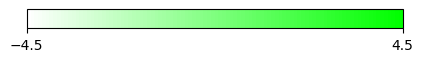

In [21]:
# @title **Visualising docked pose by LaboDock**  { display-mode: "form" }
# @markdown **Fix the parameters for visualization** \

# @markdown **PROTEIN MODEL** \
# @markdown Enter the **< Protein >** parameters to be viewed.

Protein_type = 'cartoon' # @param ['cartoon', 'cross', 'line', 'sphere', 'stick']
Protein_style = 'white' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Protein_opacity = 0.9 # @param {type: 'slider', min:0, max:1, step:0.1}
Residue_number = '' # @param {type: 'string'}
Surface_type = 'SES' # @param ['VDW', 'SAS', 'SES', 'MS']
Surface_style = 'hydrophobicity' # @param ['chain', 'white', 'whiteCarbon', 'ssJmol', 'ssPyMol', 'b factor', 'hydrophobicity', 'isoelectric points']
Surface_opacity = 0.7 # @param {type: 'slider', min:0, max:1, step:0.1}
Show_protein = True # @param {type: 'boolean'}
Show_residue = True # @param {type: 'boolean'}
Show_surface = True # @param {type: 'boolean'}
Show_gridbox = False # @param {type: 'boolean'}
grid_choice  = "/content/ABHD5/pocket_thr050_Majority0_config_2.txt"  # @param {type:"string"}

# @markdown **LIGAND MODEL** \
# @markdown Enter the **< Ligand >** parameters to be viewed.


Docked_ligand_style = 'stick' # @param ['cross', 'line', 'sphere', 'stick']
Show_docked_ligand = True # @param {type: 'boolean'}

# @markdown **INTERACTION MODEL** \
# @markdown Enter the **< Interaction Type >** to be viewed. \
# @markdown Select or combine from **`HYDROPHOBIC`**, **`HBOND`**, **`WATERBRIDGE`**,
# @markdown **`SALTBRIDGE`**, **`PISTACKING`**, **`PICATION`**, **`HALOGEN`**, **`METAL`**. \
# @markdown *Note: All interactions are selected if not provided.*

Interaction_type = "HYDROPHOBIC, HBOND, WATERBRIDGE, SALTBRIDGE, PISTACKING, PICATION, HALOGEN, METAL" # @param {type: 'string'}
Show_interaction = True # @param {type: 'boolean'}

# @markdown **OTHER OPTIONS** \
# @markdown Miscellaneous visualisation settings.

Slab_view = False # @param {type: 'boolean'}


LBSP = LaboSpace(1500, 900)
LBSP.load_receptor(protein_file_reduce)\
    .set_style(
        show_represent=Show_protein,
        represent_type=Protein_type,
        represent_style=builtin_style(
            style=Protein_style,
            opacity=Protein_opacity))\
    .add_residues(
        show_residues=Show_residue,
        residue_number=Residue_number)\
    .add_surface(
        show_surface=Show_surface,
        surface_type=Surface_type,
        surface_style=builtin_style(
            style=Surface_style,
            opacity=Surface_opacity))

LBSP.load_ligand(predicted_pose_path_pdb_H)\
    .set_style(
        show_represent=True,
        represent_type=Docked_ligand_style,
        represent_style={'colorscheme': 'salmonCarbon'})

LBSP.add_interaction(
    interaction_file=INT_profile,
    show_interaction=Show_interaction,
    select_interaction=Interaction_type)

cfg_center, cfg_bxsize = extract_config(grid_choice)

LBSP.add_gridbox(
    show_gridbox=Show_gridbox,
    center=cfg_center,
    bxsize=cfg_bxsize)

LBSP.view_space(
    slab_view=Slab_view)

show_cscale({Show_protein: Protein_style}, {Show_surface: Surface_style})
